In [1]:
%%capture
%run full_setup.py

In [2]:
from tfidf_corpus_dictionary import get_tfidf_tokendocs_corpus_dict
from gensim.models import LdaModel, LsiModel, CoherenceModel
from sklearn.decomposition import NMF, PCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

With this function we get various objects needed for modelling:
1. TFIDF matrix as input data, with specified parameters
2. feature names as the words retained with TFIDF
3. tokenized documents, a list of lists, where the inner lists contain the tokens for each document
4. corpus, gensim object needed for modelling with that package
4. dictionary, gensim object containing informations on the words of the corpus and their positions

In [3]:
tfidf_matrix, feature_names, tokenized_docs, corpus, dictionary = get_tfidf_tokendocs_corpus_dict(df, max_df=0.5, min_df=5, max_features=1000)

Now we'll evaluate different topic models based on Coherence score.

Coherence is a metric used to evalute topics quality. The higher the coherence, the better the model did in creating the topics.

For every model we'll use a function to retrieve coherence for different numbers of topics (5, 10, 15, 20, 50). This information will be used to evaluate how the models performed as the number of topics changes

In [4]:
from coherence_topics import coherence_topics
from coherence_words import coherence_words
from coherence_by_topics import coherence_by_topics

In [5]:
models = ['LDA', 'LSA', 'NMF', 'PCA', 'RP']

In [12]:
evaluation_topics = dict()

for mod in models:
    metrics = coherence_topics(model_name=mod, corpus=corpus, dictionary=dictionary,
                               texts=tokenized_docs, feature_names=feature_names, tfidf=tfidf_matrix)
    evaluation_topics[mod] = metrics

In [6]:
topics = [5, 10, 20, 50]

In [7]:
evaluation_by_topics = {}

for n_topics in topics:
    metrics = coherence_by_topics(topics = n_topics, corpus=corpus, dictionary=dictionary,
                               texts=tokenized_docs, feature_names=feature_names, tfidf=tfidf_matrix)
    
    evaluation_by_topics[n_topics] = metrics

InvalidParameterError: The 'n_components' parameter of PCA must be an int in the range [0, inf), a float in the range (0.0, 1.0), a str among {'mle'} or None. Got [[('key', 0.7422511208913135), ('government', 0.7095904923821353), ('state', 0.584384232111894), ('gun', 0.5570064607583102), ('chip', 0.5524670893037892), ('law', 0.5035123623123328), ('system', 0.4861863436810231), ('year', 0.47680835041775765), ('clipper', 0.446885513272166), ('space', 0.40846130401598546), ('encryption', 0.40834810079532147), ('distribution', 0.4048752922541798), ('work', 0.39065527657925414), ('post', 0.38854188523249944), ('case', 0.3844665458609233), ('number', 0.3838512388017438), ('point', 0.3775371712793551), ('writes', 0.3742271580586983), ('world', 0.37336454151090753), ('israel', 0.3691671139956588), ('public', 0.3670215095758356), ('kill', 0.3581793673930148), ('mean', 0.35601854835747787), ('david', 0.35305407981440445), ('israeli', 0.3471180447187608), ('armenian', 0.32619586595791583), ('information', 0.32581088038664174), ('science', 0.32302073448205887), ('country', 0.3190319033267498), ('back', 0.3181736216130425), ('phone', 0.31565761612496823), ('center', 0.3110686126959775), ('clinton', 0.30977794761395533), ('computer', 0.3091706317291127), ('start', 0.3067018313017297), ('research', 0.30089931937828807), ('bill', 0.3004695557106713), ('happen', 0.3000065252726381), ('opinion', 0.29345255235897016), ('usa', 0.2921205084921172), ('part', 0.29187552397935007), ('american', 0.2906896968675118), ('child', 0.2872124879214), ('enough', 0.2855174775948642), ('course', 0.27844503447457153), ('order', 0.2772491785927789), ('control', 0.2724043946487213), ('house', 0.2683218487157246), ('weapon', 0.2673460424716933), ('probably', 0.2649863373280322), ('idea', 0.26253637085837395), ('bad', 0.2606249320895514), ('fire', 0.25944981559136115), ('believe', 0.25845812838781507), ('person', 0.2579260454113335), ('place', 0.2559424068011389), ('put', 0.25483305833074066), ('far', 0.254568414011968), ('war', 0.2539497281546018), ('issue', 0.25289263122385164), ('steve', 0.25087665962890243), ('talk', 0.25026767505707337), ('cause', 0.24865537536204257), ('consider', 0.24484964993059405), ('drug', 0.24414236997466152), ('bank', 0.2436246883118787), ('message', 0.2433776923920999), ('police', 0.24299440152377563), ('service', 0.24157279583087748), ('technology', 0.24125761411192712), ('force', 0.2411163785865653), ('power', 0.24110166562446156), ('every', 0.24084545361132267), ('reason', 0.23909152937937184), ('provide', 0.23890400713964297), ('crime', 0.23863056339697508), ('isnt', 0.23842351908121048), ('show', 0.23832012639618744), ('support', 0.23775769270948482), ('claim', 0.23146370731927565), ('study', 0.23104867378468938), ('high', 0.23081835101815493), ('problem', 0.23045551882605564), ('etc', 0.23044954342775087), ('big', 0.22872614491368037), ('doesnt', 0.2276642944827718), ('company', 0.22749246407888365), ('money', 0.22616301603574132), ('mr', 0.22586759331777384), ('report', 0.2250449654648913), ('security', 0.22456029831598034), ('national', 0.2243389885420199), ('hear', 0.224107379555444), ('least', 0.22380370924311416), ('live', 0.22344983866832369), ('care', 0.22226482809248088), ('today', 0.22208262793425973), ('actually', 0.22162114377609152), ('leave', 0.2213852696589708), ('help', 0.22132261374005233), ('news', 0.2201900762826394), ('member', 0.21939214872770016), ('1993', 0.219147586005146), ('large', 0.21908319953128472), ('president', 0.2182485330560105), ('area', 0.21811002168247837), ('youre', 0.2173839012058431), ('attack', 0.21655529563112813), ('real', 0.21653936033011092), ('bit', 0.21629210589801806), ('communication', 0.21521354652254773), ('however', 0.21359270100044545), ('interest', 0.21138639410098578), ('hand', 0.2113485365361309), ('data', 0.21013795753149248), ('else', 0.20972267911335238), ('human', 0.20969542572976305), ('arab', 0.20902927228188825), ('arm', 0.20824343060330588), ('name', 0.2080173128050304), ('maybe', 0.20762744516399764), ('around', 0.20687931166657075), ('rather', 0.2063096663740395), ('criminal', 0.2054829058215571), ('id', 0.20537725673594823), ('na', 0.20524302572540815), ('end', 0.20418682014526493), ('ive', 0.20373700650166254), ('inc', 0.2017667458089454), ('pay', 0.20172506123540773), ('fbi', 0.20086663470740515), ('cost', 0.20085158214541313), ('source', 0.20078698937807038), ('algorithm', 0.19959856349626215), ('policy', 0.19953780655294143), ('gordon', 0.19948184906954042), ('carry', 0.19944080848324328), ('possible', 0.19924448337582676), ('send', 0.19874757819483546), ('great', 0.19862221353863252), ('secret', 0.19802270961451285), ('department', 0.19717848998624815), ('true', 0.19670488947605871), ('stop', 0.1963953851019413), ('tax', 0.1960467250419833), ('court', 0.19527843080437224), ('evidence', 0.19492924848210857), ('life', 0.1944997271587665), ('include', 0.19447501387829036), ('note', 0.1937541161501109), ('white', 0.19373478709538586), ('yes', 0.19349155920361813), ('federal', 0.19268395281955347), ('example', 0.19253957126879273), ('jew', 0.19149548065340755), ('remember', 0.19052531141141857), ('either', 0.19046085002327784), ('ago', 0.19032315947496317), ('protect', 0.19024234887162714), ('turkish', 0.19023587073208773), ('side', 0.1899352822290595), ('agree', 0.18966464134339636), ('already', 0.18919967878927427), ('small', 0.18854970910823576), ('kind', 0.18837865661757872), ('apr', 0.1873021798478334), ('private', 0.18711486813884062), ('allow', 0.18707003313117412), ('general', 0.1869779868350533), ('answer', 0.18694414541770804), ('away', 0.18584528632147546), ('sort', 0.18475151791673394), ('perhaps', 0.1845801748815877), ('citizen', 0.18409719262199364), ('job', 0.18391790109508105), ('second', 0.18313822126921808), ('de', 0.18279103904581503), ('base', 0.18269417081113423), ('jim', 0.18216022646042757), ('ca', 0.18214635034530505), ('yet', 0.18136140893158065), ('john', 0.18097342640167885), ('design', 0.18095202215727496), ('nasa', 0.18093000516357075), ('code', 0.18080762278872253), ('week', 0.18005897144479166), ('book', 0.17914884491219346), ('land', 0.1791016753243107), ('death', 0.1789013154043703), ('wrong', 0.17883463734266458), ('test', 0.17801147329458933), ('others', 0.17742282803846138), ('standard', 0.1768589086834292), ('food', 0.17651793733177962), ('political', 0.17617448351530657), ('woman', 0.17581085065439034), ('though', 0.17572414976734757), ('turn', 0.17561321161575585), ('guess', 0.17554232896720529), ('assume', 0.17487521351958007), ('access', 0.17425639374334786), ('list', 0.17394169570171125), ('wouldnt', 0.17367359694920295), ('ever', 0.17303064292604953), ('several', 0.17244048585998406), ('firearm', 0.17172097496671834), ('concern', 0.17168282125327206), ('easy', 0.17141896057658973), ('become', 0.1713266329408594), ('feel', 0.17117546727063146), ('hold', 0.17056691773161847), ('available', 0.1702942234365498), ('agency', 0.17020828175014865), ('men', 0.17002625262903887), ('view', 0.16955952379976597), ('likely', 0.16937214708923695), ('mark', 0.16897471284105656), ('result', 0.16862194455094612), ('secure', 0.1682320190401309), ('whether', 0.1663867372851554), ('legal', 0.16631343053083478), ('free', 0.1659095105230415), ('build', 0.16583001509267364), ('change', 0.16564672000274014), ('different', 0.1644655049428171), ('mind', 0.16338534095942128), ('action', 0.163031177915253), ('involve', 0.1624653527431374), ('always', 0.16233062131523682), ('effect', 0.16193109500861974), ('old', 0.1614066390069358), ('society', 0.16100768218118983), ('quite', 0.1603932487095591), ('word', 0.15989381167849492), ('guy', 0.15988932185126023), ('school', 0.15945883324251658), ('military', 0.15926452462081694), ('project', 0.15807810327970312), ('matter', 0.15758455612867714), ('amendment', 0.1571799728996274), ('begin', 0.15651988909644893), ('health', 0.1565188553834694), ('freedom', 0.15635483017290472), ('situation', 0.15624315052344054), ('able', 0.15582057980844727), ('current', 0.15489557085077404), ('murder', 0.15443553692980683), ('whole', 0.15387675485321692), ('corporation', 0.15386939384086204), ('ill', 0.15382761434367942), ('require', 0.15338523125007086), ('method', 0.15324699080448773), ('city', 0.15318867557812313), ('less', 0.153157640471419), ('individual', 0.15304424717954057), ('plan', 0.15279269345119198), ('man', 0.15268569646401403), ('act', 0.1524546848011191), ('mine', 0.1517938663867006), ('next', 0.15169672377710622), ('pat', 0.15168037697647288), ('moon', 0.15165834569306594), ('press', 0.15087348511556328), ('understand', 0.1504787019863718), ('stuff', 0.15038863515010584), ('hope', 0.1498968592936589), ('body', 0.14975523791915146), ('form', 0.14973626927383424), ('business', 0.14941349487931213), ('express', 0.1478519199708036), ('argument', 0.14768397569238628), ('institute', 0.14722571791072545), ('almost', 0.14675344425696674), ('home', 0.14619187780218154), ('population', 0.14552247877544944), ('friend', 0.14510561946353662), ('california', 0.14472913915038205), ('stand', 0.14469826176271502), ('launch', 0.14395132810768985), ('administration', 0.14384433892700257), ('strong', 0.14374760920334817), ('bring', 0.1433524210850884), ('doctor', 0.1430889556992884), ('speak', 0.14299666738096312), ('million', 0.1425368793797748), ('gmt', 0.14242160821367147), ('history', 0.1419987189822329), ('privacy', 0.14151440410034746), ('certainly', 0.14131426156957125), ('unless', 0.14085490388856503), ('theory', 0.14027276443541498), ('mention', 0.14021861633679453), ('shoot', 0.139998995667995), ('rate', 0.13957937572629128), ('set', 0.13949578122439513), ('month', 0.1394730434326968), ('product', 0.13943742585423752), ('gas', 0.1390412819963823), ('local', 0.13889033250890181), ('discussion', 0.1383388619952011), ('20', 0.13832399627229894), ('sound', 0.13744598805879732), ('level', 0.1373656761640632), ('low', 0.13735185759274915), ('wont', 0.13630604165274626), ('die', 0.1361683354153941), ('suppose', 0.13600641105883518), ('medium', 0.13578019706775615), ('charge', 0.1353357400501251), ('regard', 0.13502827273171092), ('engineering', 0.13454678096798267), ('pass', 0.1345431600686483), ('safety', 0.13436241274406696), ('enforcement', 0.13327086892398587), ('orbit', 0.13319606414713114), ('trial', 0.13285085607350497), ('learn', 0.13245975256659867), ('detail', 0.13245333532905657), ('type', 0.13240411745665662), ('difference', 0.1323961680901534), ('suggest', 0.13215930178862373), ('internet', 0.13200484323720524), ('face', 0.13173776274404486), ('cut', 0.13164017992917254), ('kid', 0.13158468124843167), ('figure', 0.13133680439030918), ('fund', 0.13132204333703246), ('rule', 0.13089358546905372), ('office', 0.13079470491052891), ('prevent', 0.13063546172742663), ('certain', 0.1304426905462477), ('trust', 0.13038596274672642), ('email', 0.13014377577901493), ('value', 0.1300088213021076), ('bike', 0.12968774654224913), ('apply', 0.12958232165842845), ('explain', 0.12947613401370803), ('story', 0.1294070056570586), ('party', 0.12930418567061017), ('break', 0.12926953932868596), ('april', 0.12873913985071705), ('statement', 0.12871228407132834), ('medical', 0.12843181037406948), ('ten', 0.128165839541913), ('head', 0.12776606104580304), ('fight', 0.12735079040596206), ('black', 0.12693799003997405), ('cover', 0.12693639871871276), ('22', 0.12689801732029057), ('reference', 0.12611054943521813), ('15', 0.12561947885105487), ('three', 0.1254385580435879), ('pretty', 0.12520519574841907), ('deal', 0.1250098256127249), ('check', 0.12473781692758341), ('develop', 0.12464543188767903), ('process', 0.12450533365039389), ('decide', 0.12407285878865748), ('purpose', 0.12403018111056478), ('continue', 0.12392462546832349), ('disease', 0.12360474546332605), ('inreplyto', 0.12357057866153998), ('address', 0.12351600607492366), ('ground', 0.12310453745947002), ('msg', 0.12302594008397164), ('exist', 0.1229396127409174), ('10', 0.12289602976447146), ('simply', 0.12270496778465281), ('water', 0.1224925769911009), ('cheap', 0.12174254066441159), ('18', 0.121730341809249), ('buy', 0.1213570191593528), ('within', 0.12132560088674736), ('congress', 0.12096272929043582), ('dod', 0.12085338478927811), ('clear', 0.12067529882147317), ('device', 0.12049086456787217), ('program', 0.12038482893433348), ('paper', 0.12030520821245515), ('block', 0.12021828608818991), ('univ', 0.12012722066798287), ('open', 0.12005650097895515), ('michael', 0.11998260918936078), ('experience', 0.11990684391001125), ('whatever', 0.11959936863942776), ('armenia', 0.1191914844274066), ('couple', 0.11884272439219197), ('19', 0.11843106320253852), ('wonder', 0.11788261715155629), ('request', 0.1178377276031531), ('burn', 0.11768349242123034), ('close', 0.11750921707999283), ('often', 0.11733747166964434), ('market', 0.11693503335098204), ('move', 0.11691476234839043), ('similar', 0.11684561993532612), ('letter', 0.11630840219292962), ('release', 0.11626806176414844), ('texas', 0.11626015294299623), ('station', 0.11623145521468543), ('dept', 0.11616332623035894), ('peace', 0.11594113202152934), ('chance', 0.11577943759241142), ('quote', 0.11552159176053352), ('17', 0.11550985318295508), ('exactly', 0.11541731787024753), ('user', 0.11500586940420335), ('comment', 0.11500492338847623), ('11', 0.11488309087294449), ('york', 0.11487449932899926), ('increase', 0.11483730619609153), ('anyway', 0.11441694098841959), ('bear', 0.11401700482484202), ('family', 0.11400711749979273), ('16', 0.11396514612229247), ('education', 0.11394704927115629), ('per', 0.11379124547241969), ('tim', 0.11371716829306452), ('common', 0.1136862329250927), ('amount', 0.11363698961464086), ('united', 0.11363619068919929), ('spend', 0.11347352557839262), ('radio', 0.11344149504508207), ('receive', 0.11325794785493906), ('serious', 0.11317660725172216), ('practice', 0.11263572008984515), ('21', 0.112577589999384), ('soon', 0.11253111282503359), ('fail', 0.11240540699616917), ('greek', 0.11233499974205477), ('attempt', 0.1120200467079106), ('follow', 0.11183017864796338), ('response', 0.11178573654703429), ('light', 0.11177715019800773), ('important', 0.11149075868048754), ('past', 0.11100207122443101), ('instead', 0.1107723796537669), ('term', 0.11069675124906846), ('mail', 0.11064529319294396), ('present', 0.11054073404100351), ('short', 0.1105344437029816), ('simple', 0.11044723814303248), ('wish', 0.11031076189344878), ('single', 0.11025916233672758), ('doubt', 0.11019987283110694), ('thousand', 0.11010277398827227), ('posting', 0.10982057263388907), ('international', 0.10979276900579006), ('sense', 0.10950999850044384), ('official', 0.1091417822256413), ('produce', 0.10908597019328156), ('soldier', 0.10886260180610312), ('except', 0.10885663456612049), ('saw', 0.10859312534347815), ('theres', 0.10849524254218441), ('13', 0.10845677266601915), ('major', 0.10837962212505825), ('risk', 0.10837169322307168), ('lead', 0.1083477862107845), ('turk', 0.1081660358881757), ('nazi', 0.10805444685821253), ('publish', 0.1079239514650877), ('arent', 0.10721936558477868), ('lab', 0.10719792091611222), ('air', 0.1071270716133412), ('stupid', 0.10707626656336162), ('germany', 0.10705247082936503), ('93', 0.10693378200767077), ('disclaimer', 0.10692551029891369), ('turkey', 0.10680962675018837), ('voice', 0.10672238481929688), ('network', 0.10661611464144069), ('technical', 0.10659115952029401), ('listen', 0.10656054327847363), ('sign', 0.10644191890834262), ('date', 0.10637936350277391), ('earth', 0.10631401863785171), ('road', 0.10610630709199312), ('personal', 0.1060322774249976), ('corp', 0.10586465165015771), ('serve', 0.10570289011819602), ('argue', 0.10545658282396779), ('student', 0.10533676190085568), ('dead', 0.10527440845536731), ('vote', 0.10516722043374994), ('commercial', 0.10504908263550464), ('hour', 0.10490918668295161), ('best', 0.10489206027794377), ('return', 0.1047776774271335), ('suspect', 0.10456235438773796), ('wait', 0.10430180979236331), ('hit', 0.10428474267564715), ('havent', 0.10428296737786952), ('whats', 0.10362684587199862), ('san', 0.10362294438232016), ('washington', 0.10319944484648207), ('expect', 0.10313857945970348), ('class', 0.1030687478901571), ('appear', 0.10305225180344431), ('keywords', 0.10298625663208011), ('thus', 0.10295671813953204), ('folk', 0.10278320578780312), ('insurance', 0.10266946748050634), ('ie', 0.10263105934049284), ('full', 0.1024972939185351), ('outside', 0.10245346942605181), ('add', 0.10227283882241102), ('usually', 0.10195826927485574), ('ed', 0.1019417929269915), ('community', 0.10192047971425922), ('online', 0.10190675051320588), ('realize', 0.10169165487976063), ('event', 0.1013213726783462), ('watch', 0.10122011809410716), ('limit', 0.10094639302726927), ('activity', 0.1007825580249082), ('describe', 0.10056072077202059), ('imagine', 0.10025419341263331), ('mass', 0.10011999630080305), ('future', 0.10009648443685357), ('robert', 0.10003521635128848), ('newsgroup', 0.09988904114637673), ('upon', 0.09985681416569901), ('frank', 0.09942503154126228), ('25', 0.09913680531695822), ('interested', 0.09884749257605592), ('approach', 0.09850831325036896), ('eat', 0.09835903283955445), ('fall', 0.09831535489967354), ('later', 0.09805319217842473), ('everything', 0.09786527940350664), ('muslim', 0.0978247177915858), ('especially', 0.09781224620832933), ('articleid', 0.09771401531413337), ('russian', 0.09728586397596917), ('fax', 0.09679159630329112), ('solution', 0.0966889844599483), ('30', 0.09665433341154332), ('among', 0.0964968579434556), ('necessary', 0.09600503762111952), ('rest', 0.0957466177694393), ('forget', 0.0957075716487118), ('nice', 0.09546264129392318), ('position', 0.09539306654409617), ('street', 0.0953229815410037), ('authority', 0.09528716132750167), ('al', 0.09515082191086813), ('commit', 0.09500121515169686), ('james', 0.09498809524017539), ('difficult', 0.09490673803587896), ('behind', 0.09484520118767921), ('due', 0.09481917729058394), ('effort', 0.09466458900743714), ('scientific', 0.09463306954798048), ('building', 0.09461817442009472), ('correct', 0.09457937779702583), ('worth', 0.09448915076167692), ('keith', 0.09446664391323109), ('occur', 0.09431545475357452), ('thomas', 0.09427276953907399), ('net', 0.09408678772842514), ('text', 0.0939285484534506), ('america', 0.09377835034628719), ('xnewsreader', 0.09376278356723095), ('early', 0.09362381388806876), ('machine', 0.09362014910329056), ('particular', 0.09343085477283763), ('info', 0.09339237016826943), ('special', 0.09328851261138937), ('dr', 0.09324657278848268), ('george', 0.0930546550750167), ('flame', 0.09297801801177788), ('happy', 0.09290111383604457), ('development', 0.09280592455129104), ('summary', 0.09270552537578437), ('lie', 0.09265251738528979), ('wasnt', 0.09264578605224708), ('field', 0.09243914715867017), ('couldnt', 0.09235791755083281), ('prove', 0.09224976842928637), ('aid', 0.09187428428249994), ('discuss', 0.09172080470237857), ('apparently', 0.09170815595952363), ('uk', 0.09168535209038534), ('operation', 0.09159065250198338), ('step', 0.0915869572890179), ('obvious', 0.09152381490923954), ('otherwise', 0.09151514197611543), ('western', 0.09146326315362549), ('search', 0.09126259047325902), ('door', 0.09121642155261259), ('define', 0.09121642067430806), ('ok', 0.09101086406071263), ('clearly', 0.09098590737082232), ('tv', 0.09066286257939102), ('inside', 0.09060979892110013), ('measure', 0.09046141585372382), ('stay', 0.09038887178515713), ('copy', 0.09030371789624274), ('dave', 0.09004765143132626), ('canada', 0.0900270932674219), ('paul', 0.08999862780052513), ('jewish', 0.0896408617723433), ('nation', 0.08962121201647044), ('sit', 0.08955512268344419), ('vehicle', 0.0891742506930132), ('function', 0.0888263852521125), ('12', 0.08855563298385874), ('count', 0.08845140763213247), ('half', 0.08833535801623849), ('avoid', 0.0882393678606848), ('night', 0.08816176405169708), ('defense', 0.08751782023419033), ('near', 0.08745898097342945), ('notice', 0.08732349518766265), ('top', 0.0872772060342264), ('reduce', 0.08725349881592498), ('andrew', 0.08719255799402387), ('blood', 0.08710551127588988), ('23', 0.08699684635917361), ('along', 0.08696872285567629), ('young', 0.08692987443209034), ('interesting', 0.08674097787722478), ('tool', 0.08524020331231176), ('refer', 0.08511049444712157), ('shall', 0.08484347324182102), ('thought', 0.08471334097087617), ('contain', 0.0845369975746437), ('raise', 0.0842682633399261), ('although', 0.08397240089616623), ('record', 0.0839138567693953), ('moral', 0.0837800369255942), ('lose', 0.08331112863487462), ('ride', 0.08310066771093925), ('chris', 0.08280961284422336), ('lack', 0.08274831967583443), ('completely', 0.08247805776641437), ('meet', 0.08222892523422447), ('wife', 0.08215091550721366), ('account', 0.08210248452289073), ('associate', 0.08179843257284856), ('dan', 0.08171723566613391), ('replace', 0.08161042566858026), ('satellite', 0.08124512859388491), ('scott', 0.08115898678230798), ('determine', 0.0807844525110797), ('reasonable', 0.08069979257251016), ('accord', 0.08067811447486138), ('tom', 0.08062799487482886), ('material', 0.08053551414157535), ('pull', 0.08051495724083493), ('unit', 0.08049984374754562), ('jon', 0.08029734179854602), ('accept', 0.08023568098188964), ('intend', 0.08023169524751422), ('total', 0.08013616070784962), ('judge', 0.08012750333244255), ('front', 0.08008245478739286), ('obtain', 0.07984391855710118), ('miss', 0.07978162234816796), ('depend', 0.07928705664205178), ('willing', 0.07922061324041013), ('none', 0.0790710046976508), ('minute', 0.07889544048362004), ('26', 0.07889336562560478), ('mission', 0.07868349608009075), ('obviously', 0.07819255712755824), ('basic', 0.07813537663468992), ('run', 0.07813239596788812), ('remain', 0.07795971021481966), ('age', 0.07782028143733906), ('eye', 0.07745722234788728), ('choose', 0.07707308955066855), ('reach', 0.07705386422474149), ('main', 0.07674406739863193), ('normal', 0.07673026138140242), ('pittsburgh', 0.0765120445942408), ('previous', 0.07635765190230026), ('decision', 0.0763228013934131), ('peter', 0.07618581912759707), ('100', 0.07599601372067034), ('throw', 0.07575724268229177), ('mike', 0.0756938775973054), ('appreciate', 0.07553417947882411), ('average', 0.07535356155623636), ('colorado', 0.0753461320600093), ('establish', 0.07528400422117439), ('sun', 0.0750588318894618), ('compare', 0.07504595915728822), ('smith', 0.07493432680348959), ('shot', 0.07472880330219664), ('eg', 0.07453872867024648), ('usenet', 0.0745268434905157), ('14', 0.07443511107930674), ('rid', 0.07442664863808132), ('four', 0.07422268354363813), ('drop', 0.07362857225178221), ('illinois', 0.07357440032596572), ('fit', 0.07356601781539777), ('page', 0.07354795458115088), ('reserve', 0.07350831202462298), ('license', 0.07336926769556319), ('whose', 0.07315383650172182), ('religious', 0.0730924606267178), ('foot', 0.0728640749215184), ('relate', 0.07284926652472413), ('28', 0.07277555607879269), ('laboratory', 0.07261840495446834), ('indeed', 0.072569013009918), ('27', 0.07256894290607212), ('box', 0.07256602488645716), ('software', 0.0725538250235391), ('easily', 0.07228864806305783), ('recent', 0.07221715320696491), ('hole', 0.07191503572206065), ('south', 0.07171304149875837), ('specific', 0.07148873127192296), ('heard', 0.07131417232058274), ('object', 0.07088299338603814), ('1992', 0.0705892915566073), ('evil', 0.07053611094077192), ('knowledge', 0.07006882893312541), ('create', 0.07000264204256323), ('appropriate', 0.06997712256654563), ('unfortunately', 0.06991835711128398), ('grant', 0.06985016290958797), ('west', 0.06975973686649625), ('btw', 0.06974423433176077), ('sell', 0.0696913961367977), ('leader', 0.0696785877387969), ('objective', 0.06938112550772478), ('ii', 0.06911421264715129), ('late', 0.06908531182859287), ('draw', 0.06854314626335181), ('pick', 0.06839409727587513), ('range', 0.0682500128932937), ('reply', 0.0679877693833935), ('college', 0.0678548787308664), ('version', 0.06776316375649968), ('hell', 0.06770142481366388), ('respect', 0.06764737457322378), ('originator', 0.06709047913585336), ('supply', 0.06684552242575335), ('recently', 0.06684340863573361), ('period', 0.0667393984684771), ('youll', 0.06667653626875814), ('basis', 0.06635214306475586), ('section', 0.06627450094901811), ('circuit', 0.06626891072156008), ('generally', 0.06610888876237297), ('picture', 0.066020040497361), ('sometimes', 0.06597924223474594), ('various', 0.06591129404210187), ('tin', 0.06546882503606302), ('currently', 0.06515243582302653), ('third', 0.06497452598069207), ('ny', 0.06496192574988946), ('29', 0.06490833323319872), ('neither', 0.0647661899905312), ('useful', 0.06467925003062307), ('option', 0.06458359805545436), ('quality', 0.06428882281479448), ('religion', 0.0639451148564041), ('together', 0.06391918182805177), ('finally', 0.06390544470460865), ('size', 0.0638439769529221), ('choice', 0.06328571016426471), ('addition', 0.0631970911970274), ('clock', 0.06282912651410211), ('32', 0.0627775679438104), ('electronic', 0.06265654063029154), ('delete', 0.062466938043332), ('contact', 0.06216776343888597), ('advice', 0.06189172612855987), ('purchase', 0.06139594329890517), ('forward', 0.06117277474230455), ('respond', 0.06100868031707184), ('40', 0.06100588159526676), ('bob', 0.060722402226146256), ('dog', 0.06051175504102363), ('compute', 0.06048174781514833), ('doug', 0.06047143657781289), ('faq', 0.060415180508951796), ('50', 0.06040921538316705), ('share', 0.06035049309515122), ('store', 0.06033819448436839), ('richard', 0.05984797692094334), ('signal', 0.05984412114474708), ('via', 0.059739118229356875), ('original', 0.059461210741735), ('therefore', 0.059387799283818994), ('suggestion', 0.05931055260865577), ('love', 0.059279091503071396), ('handle', 0.05927803587389346), ('site', 0.05914306099194157), ('room', 0.05884808496841352), ('north', 0.058730921852882936), ('truth', 0.057394415026495824), ('gary', 0.05736016547784209), ('entire', 0.05723100918635408), ('author', 0.057213103862746424), ('error', 0.05713288171113111), ('chicago', 0.057022597105013235), ('conference', 0.0564923625817137), ('necessarily', 0.056376708975291144), ('resource', 0.05602684667015851), ('hard', 0.055966177051546634), ('24', 0.055769054080114566), ('definition', 0.05560222285269413), ('document', 0.05520626119891958), ('following', 0.05481527994543332), ('ability', 0.05467202617458402), ('magazine', 0.054440943466410444), ('ad', 0.054424992923732284), ('33', 0.05428006310612026), ('bb', 0.054242371470214094), ('link', 0.054222822906663824), ('language', 0.05421652933356598), ('directly', 0.053915814250497254), ('digital', 0.05369836139635489), ('80', 0.053647804222120093), ('heart', 0.0533782634574547), ('oil', 0.05336041432248426), ('complete', 0.053260715488098735), ('king', 0.053069436913828115), ('los', 0.052960497882492255), ('la', 0.05292167883802371), ('remove', 0.05233973702044257), ('nature', 0.05206487436459192), ('division', 0.0514691556415157), ('archive', 0.05131022773363314), ('direct', 0.0510084624751354), ('conclusion', 0.050947208232653654), ('review', 0.05011250319157104), ('image', 0.05011136756893447), ('condition', 0.050024117949979706), ('serial', 0.04974217437591931), ('final', 0.04966229728811073), ('trouble', 0.0496353140380441), ('east', 0.0492779790926736), ('34', 0.04910096114613914), ('morality', 0.04908929322217602), ('60', 0.04899815151028575), ('alone', 0.04895955997758299), ('38', 0.04847697020240177), ('toronto', 0.048406871063759495), ('package', 0.04804615455005296), ('owner', 0.04786177798838062), ('unix', 0.04777594494993217), ('context', 0.047479875153862906), ('stick', 0.04703740788231128), ('wire', 0.045522932414489826), ('hardware', 0.04490381120417386), ('fast', 0.04472355808736195), ('model', 0.04456594844285292), ('engine', 0.04436960017047868), ('library', 0.044225334930141226), ('anonymous', 0.04374659026899378), ('round', 0.04340110221526291), ('42', 0.04284323651440678), ('37', 0.042546994824816366), ('beat', 0.04241380053562881), ('environment', 0.04183393473441887), ('star', 0.04093449967816299), ('character', 0.04068929776813639), ('fine', 0.04052504333386389), ('european', 0.040365887135387565), ('44', 0.040225868826124764), ('dealer', 0.040049704822993665), ('advance', 0.03950358603227097), ('georgia', 0.03816753179080316), ('keyboard', 0.037328442097640004), ('boston', 0.03727231838011939), ('36', 0.03708844536120124), ('application', 0.037076253770464085), ('command', 0.03701753976035077), ('mile', 0.036943045711488744), ('red', 0.0366332434894638), ('input', 0.036556307851158654), ('output', 0.03596774352610312), ('title', 0.0342811380703302), ('teach', 0.034024727369649364), ('brian', 0.033872009867941186), ('save', 0.03309929028306921), ('speed', 0.03242469765892278), ('trade', 0.03202760306052), ('father', 0.0316949340238178), ('slow', 0.031395766629238556), ('son', 0.0313929996723252), ('fix', 0.03133470592169064), ('van', 0.029650399131355552), ('price', 0.029280916883456434), ('45', 0.029003589818031656), ('matthew', 0.028984976588443352), ('goal', 0.028746785920061142), ('item', 0.028036628086085015), ('ibm', 0.02781207109073112), ('series', 0.027134417390500154), ('tape', 0.026990575607878018), ('motif', 0.026291518138426312), ('41', 0.026223316802444933), ('transfer', 0.024101460889446206), ('eric', 0.02231450364395321), ('load', 0.022294708269197615), ('church', 0.02224751015281973), ('feature', 0.020967825836669295), ('plus', 0.020967141475744883), ('internal', 0.020483164682598833), ('st', 0.020444853531965564), ('db', 0.019628671907083076), ('3d', 0.018940077873719485), ('server', 0.01874799788701021), ('35', 0.01846700565197424), ('board', 0.018281049934189816), ('offer', 0.017788208180709388), ('connect', 0.017577195974782717), ('existence', 0.01686112009359081), ('atheist', 0.016021847159801456), ('switch', 0.015496643126941472), ('blue', 0.015112577832638613), ('excellent', 0.014448423326834966), ('ship', 0.014288698442982454), ('print', 0.01346903423341084), ('client', 0.01336896993637518), ('convert', 0.013234654293258312), ('performance', 0.012871381469380222), ('car', 0.011386386795214013), ('stephanopoulos', 0.01093420942814925), ('entry', 0.010513902946060465), ('pin', 0.009461915401314658), ('display', 0.008240604795586928), ('widget', 0.007876903584231806), ('550', 0.005756418853904155), ('fan', 0.005642326415837563), ('hp', 0.004956556337428059), ('ftp', 0.0031974930661083562), ('wing', 0.0012806100881821488), ('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 4.873792712693394e-05), ('drive', 0.0), ('sale', 0.0), ('printer', 0.0), ('faith', 0.0), ('bible', 0.0), ('directory', 0.0), ('season', 0.0), ('format', 0.0), ('nhl', 0.0), ('disk', 0.0), ('scsi', 0.0), ('driver', 0.0), ('screen', 0.0), ('sin', 0.0), ('file', 0.0), ('score', 0.0), ('port', 0.0), ('league', 0.0), ('belief', 0.0), ('font', 0.0), ('31', 0.0), ('floppy', 0.0), ('ram', 0.0), ('baseball', 0.0), ('apple', 0.0), ('jesus', 0.0), ('memory', 0.0), ('pc', 0.0), ('color', 0.0), ('cd', 0.0), ('manual', 0.0), ('manager', 0.0), ('instal', 0.0), ('card', 0.0), ('christianity', 0.0), ('mac', 0.0), ('christian', 0.0), ('christ', 0.0), ('interface', 0.0), ('lord', 0.0), ('video', 0.0), ('ide', 0.0), ('play', 0.0), ('mouse', 0.0), ('graphic', 0.0), ('game', 0.0), ('upgrade', 0.0), ('playoff', 0.0), ('bus', 0.0), ('cable', 0.0), ('monitor', 0.0), ('modem', 0.0), ('windows', 0.0), ('team', 0.0), ('window', 0.0), ('pt', 0.0), ('hockey', 0.0), ('win', 0.0), ('mode', 0.0), ('controller', 0.0), ('player', 0.0), ('god', 0.0)], [('window', 1.54964133105691), ('file', 1.2582611956139982), ('program', 0.7127353395221347), ('run', 0.4604110359579201), ('version', 0.42805878486577026), ('driver', 0.3838452937403034), ('problem', 0.358826836285147), ('help', 0.35278280581680826), ('graphic', 0.3316911280226295), ('application', 0.32730838752258273), ('31', 0.3219859816217643), ('image', 0.32181486265731113), ('color', 0.2951251891078624), ('email', 0.29351264621699047), ('display', 0.2798406236175075), ('server', 0.2762145648097683), ('11', 0.25978847033318897), ('system', 0.2597379079910146), ('ftp', 0.25823870859405407), ('manager', 0.25562463854110806), ('windows', 0.25107075221215946), ('screen', 0.23965795233941528), ('software', 0.2284712153137089), ('work', 0.22772086860300442), ('directory', 0.22120516616301686), ('format', 0.21361220763977587), ('xnewsreader', 0.20440757902445064), ('font', 0.2031061761511679), ('tin', 0.1987791408207752), ('memory', 0.19725262724461334), ('pc', 0.1946581172420616), ('card', 0.19380710821246394), ('available', 0.19235523804427285), ('internet', 0.19013936810989018), ('user', 0.18876944585547972), ('create', 0.18719999779797755), ('set', 0.1815426561454868), ('advance', 0.1812239736907984), ('code', 0.1804641584327863), ('package', 0.17582240340836305), ('information', 0.17525107790566294), ('mouse', 0.17245662870514705), ('computer', 0.17231341951792065), ('change', 0.16839789711133793), ('error', 0.1674509733200725), ('video', 0.16704780065062363), ('mode', 0.15903630494590704), ('widget', 0.15335673674444503), ('fax', 0.1533238199705943), ('machine', 0.15158666581086083), ('motif', 0.15092258265390077), ('keywords', 0.1509217441832589), ('site', 0.14875184811039222), ('data', 0.1470799151577569), ('mail', 0.144589145354309), ('copy', 0.1437311288924114), ('access', 0.14260807500166378), ('source', 0.1402497974806317), ('unix', 0.1392238023228143), ('sun', 0.1345549029327818), ('support', 0.13367664772293505), ('send', 0.13098702666354195), ('ive', 0.13010872566450882), ('convert', 0.1289263388897702), ('distribution', 0.1286341320282889), ('appreciate', 0.12792169013301954), ('include', 0.12353652036248386), ('client', 0.12267962304115242), ('address', 0.12204201007102343), ('library', 0.12173419447804114), ('printer', 0.12068870377965685), ('info', 0.11976969873286021), ('name', 0.11672412699452707), ('science', 0.11436667739983043), ('draw', 0.11158747515991181), ('print', 0.11117478977158844), ('disk', 0.11073899283345712), ('network', 0.11066114887821658), ('list', 0.11056187079473542), ('post', 0.10886962491574534), ('3d', 0.10638655500450249), ('inc', 0.1061898317734205), ('message', 0.10296603779783153), ('15', 0.10241866966359638), ('size', 0.10198059445768147), ('load', 0.10133422766598925), ('bit', 0.10050028210593451), ('space', 0.09859788723295393), ('function', 0.0977326032131876), ('michael', 0.09746873996137244), ('via', 0.09589029760540813), ('faq', 0.0957307733411566), ('object', 0.09477583383340552), ('30', 0.09460685635693243), ('delete', 0.09426883813042539), ('10', 0.09386151054934112), ('text', 0.09380822432989008), ('command', 0.09374188516291289), ('world', 0.09361640864309745), ('16', 0.09357521141506255), ('etc', 0.0935072633097713), ('technology', 0.09330290226967204), ('instal', 0.09023334644885601), ('product', 0.08887729145915219), ('possible', 0.0888679216375763), ('environment', 0.08827207418884107), ('dept', 0.08757705069337239), ('simple', 0.08637584654958942), ('type', 0.08620737800093041), ('character', 0.08602794877917887), ('institute', 0.08561588164620643), ('24', 0.08414592233029784), ('20', 0.08408079114988269), ('port', 0.08341225618889472), ('event', 0.08322580278928614), ('12', 0.08305648962444417), ('fine', 0.08305477535014152), ('resource', 0.08288363179984637), ('research', 0.08282915404346096), ('feature', 0.081812968849176), ('ram', 0.08063123848152096), ('box', 0.08005792370746499), ('check', 0.0795839501170001), ('output', 0.0794270745359697), ('add', 0.07892884216682751), ('hardware', 0.07872978508380332), ('start', 0.07792405373992675), ('reply', 0.07785866434979395), ('monitor', 0.07600063674404266), ('open', 0.07554324501956534), ('following', 0.07226763867896903), ('answer', 0.07203024873719592), ('value', 0.07131600988301255), ('fix', 0.07103688497281657), ('able', 0.0710368448474252), ('picture', 0.0708271138807243), ('fast', 0.0703570037472554), ('id', 0.07026630043809422), ('option', 0.06988604189481337), ('slow', 0.06966655638667776), ('book', 0.06852119946425246), ('ibm', 0.06835680490055404), ('move', 0.06825075003550209), ('interface', 0.0675891547157015), ('idea', 0.06753642707348148), ('request', 0.0674183930569229), ('engineering', 0.067318530296296), ('22', 0.06622389042877815), ('view', 0.0647164162398922), ('reference', 0.06465111542377551), ('correct', 0.06455656877812899), ('provide', 0.0641771757594842), ('win', 0.06416397499659963), ('hp', 0.06415491177808119), ('david', 0.06335849523037762), ('standard', 0.06319731791478951), ('tool', 0.0631014409597153), ('wonder', 0.06307557872331263), ('phone', 0.06286281064996278), ('late', 0.06243886835234919), ('contain', 0.06239920767502695), ('release', 0.06204133580758663), ('stuff', 0.0620046132809524), ('32', 0.0619393197434631), ('current', 0.06146820300446346), ('department', 0.06136853549853077), ('compute', 0.06108920489068593), ('several', 0.06097186725436008), ('laboratory', 0.06056945300529874), ('mac', 0.06052687697818661), ('title', 0.060305220017032556), ('uk', 0.060220453958599166), ('build', 0.060110998940949394), ('17', 0.060050470406735994), ('ie', 0.05994896063880568), ('summary', 0.059867144779713014), ('board', 0.05978430899980239), ('different', 0.059710716570902156), ('13', 0.059159823355687854), ('georgia', 0.059025199689600454), ('allow', 0.058454203179845204), ('number', 0.05839861980517644), ('keyboard', 0.0583852395270465), ('usa', 0.05819818307738833), ('19', 0.05813418434273238), ('14', 0.05787597184826277), ('appear', 0.057445512652088256), ('canada', 0.05741559269883319), ('communication', 0.057150854239820775), ('doesnt', 0.05711733734790497), ('23', 0.05688671572017259), ('news', 0.0566149737561952), ('public', 0.05655177291311882), ('entry', 0.05595016392214192), ('anonymous', 0.0552846397566678), ('suggestion', 0.0548397926468816), ('page', 0.05404190184287909), ('free', 0.05372020966038249), ('ca', 0.05335224346496694), ('currently', 0.05294944933972535), ('author', 0.05214431324694244), ('result', 0.05205363060973511), ('input', 0.051956919730118324), ('require', 0.05098363261262996), ('hope', 0.0509313572488997), ('robert', 0.05089185532888478), ('apr', 0.05085318161531918), ('example', 0.050701226034924), ('service', 0.05065766352268555), ('solution', 0.050302125377888876), ('project', 0.049979247920094914), ('however', 0.04995570911692467), ('online', 0.04989621374910618), ('germany', 0.049870996514056284), ('share', 0.04956240457282092), ('save', 0.04867229841093638), ('1993', 0.04864777294475586), ('date', 0.04860758774908893), ('modem', 0.04853260635414724), ('class', 0.048518552156985285), ('peter', 0.04850541358646791), ('bb', 0.04845900155504271), ('college', 0.048075073327339825), ('position', 0.047559072532131264), ('response', 0.04731953452980943), ('easy', 0.04692591140892672), ('21', 0.046857646106679564), ('connect', 0.046788486836028646), ('unfortunately', 0.04663439236929677), ('top', 0.04648842696878196), ('control', 0.045937472268295476), ('mark', 0.045841596388747845), ('manual', 0.04529240529692792), ('instead', 0.04512515405703805), ('richard', 0.04465577439352349), ('national', 0.04447220637090964), ('newsgroup', 0.044378012234786095), ('voice', 0.04431573676415469), ('return', 0.044154031210386635), ('writes', 0.04396288903983718), ('sound', 0.04390252176189019), ('small', 0.04386602937574422), ('corporation', 0.043525829739119025), ('note', 0.04352368418747075), ('everything', 0.043520456880738134), ('center', 0.04324310850443682), ('else', 0.04285371191759013), ('regard', 0.04260433218625898), ('either', 0.04258958169964943), ('recently', 0.04246008688620375), ('tom', 0.04215151910343983), ('test', 0.04199972913332315), ('archive', 0.0419339191697378), ('originator', 0.04132132991322131), ('40', 0.04115929647723158), ('section', 0.04114846171499924), ('search', 0.04104922287423008), ('steve', 0.04093702901536867), ('press', 0.04088168961466458), ('net', 0.040859728682548786), ('chris', 0.04077400432212549), ('handle', 0.04014324640613142), ('articleid', 0.039652118462979266), ('serial', 0.0395898493716493), ('technical', 0.03954340456713684), ('word', 0.03953388780228742), ('link', 0.039452192373584695), ('item', 0.03927489410004135), ('brian', 0.03910493582092771), ('process', 0.038985364882351034), ('18', 0.03895568714477472), ('language', 0.03803761472959021), ('interested', 0.03800116980096719), ('thomas', 0.037580789780585246), ('respond', 0.03753368611445413), ('gmt', 0.03741720465783383), ('specific', 0.03728817678397006), ('development', 0.03706661280931891), ('50', 0.03697670071220986), ('comment', 0.036908784281438414), ('ok', 0.03682976643336179), ('contact', 0.03673486824055327), ('already', 0.036724719984770116), ('base', 0.0365567837059976), ('define', 0.036396320890503944), ('follow', 0.03631480603802117), ('similar', 0.036205351979579165), ('receive', 0.036120571510900985), ('large', 0.036091773411533835), ('nice', 0.03559078464570603), ('design', 0.03536010530111787), ('original', 0.03525329500004003), ('youll', 0.035181497635291846), ('place', 0.035168983185191204), ('eric', 0.03481102803779335), ('around', 0.03476451092249574), ('actually', 0.03468901842584044), ('lab', 0.034630754150949565), ('de', 0.03440774465735135), ('33', 0.03439658544342444), ('mike', 0.034155883508119836), ('experience', 0.03383360383637106), ('school', 0.03366995855798566), ('wrong', 0.03352138562332779), ('25', 0.03328727948218616), ('accept', 0.03317934779087203), ('switch', 0.03313301637263836), ('point', 0.03302207150661418), ('pretty', 0.03298196216768959), ('various', 0.03281795396573336), ('john', 0.03255156627513785), ('probably', 0.031906289106250874), ('company', 0.03165121980500531), ('express', 0.03165018112697155), ('ill', 0.03132590222948973), ('office', 0.03122383099757929), ('trouble', 0.03113778637124384), ('international', 0.031083935738552313), ('though', 0.030785841980208627), ('scott', 0.03064896755610552), ('44', 0.030536729629302494), ('full', 0.030526613941442952), ('show', 0.030159778846506027), ('st', 0.030035899531875448), ('main', 0.029982585578047047), ('algorithm', 0.02983258428331427), ('turn', 0.029672377493954325), ('document', 0.02962312436773868), ('next', 0.02940593940438423), ('anyway', 0.029141665724032838), ('obtain', 0.028941026117875582), ('eg', 0.028916060752980654), ('corp', 0.028832264078982716), ('sometimes', 0.028767907853377916), ('develop', 0.028720806912467048), ('operation', 0.028319917575228747), ('remove', 0.028316719231305156), ('license', 0.028038081591357567), ('associate', 0.027978558613665792), ('always', 0.027927567595210822), ('complete', 0.02776520777918555), ('review', 0.027737292997839346), ('26', 0.027669647185089703), ('home', 0.027388563907614585), ('upgrade', 0.027315840572032107), ('necessarily', 0.02712134730425229), ('ed', 0.02684940503017195), ('posting', 0.0265661369600633), ('60', 0.026462216112802923), ('dave', 0.02628551306013726), ('cause', 0.026193850707403037), ('tim', 0.02616618153285269), ('useful', 0.026043896778543643), ('93', 0.025976092488594494), ('soon', 0.02588227896808183), ('couple', 0.025458792433926136), ('mean', 0.025351223748665334), ('inreplyto', 0.025322358939308193), ('commercial', 0.025319340445740843), ('notice', 0.02525074664396675), ('directly', 0.02523691688436428), ('suggest', 0.025174461152870246), ('univ', 0.02513947220807754), ('exist', 0.025131545253049458), ('van', 0.02510184125684736), ('general', 0.024860576759289106), ('local', 0.02480008512578446), ('theres', 0.02473465295210651), ('basic', 0.024714384820804562), ('chicago', 0.024702824412069162), ('electronic', 0.02460430348096917), ('store', 0.02451662164814202), ('happen', 0.024458784495678954), ('every', 0.02437380296676218), ('quality', 0.024331938028654857), ('level', 0.024300635768075108), ('yet', 0.02428505179893597), ('rather', 0.024234768772847217), ('depend', 0.02393645444095059), ('42', 0.023792301241421402), ('27', 0.023737800766774727), ('expect', 0.023736165014820607), ('maybe', 0.02354623916826523), ('normal', 0.02351931264767549), ('exactly', 0.023359824261675308), ('wait', 0.02334624984359762), ('paper', 0.023318061219615056), ('put', 0.023220766440539203), ('real', 0.02309486721958166), ('figure', 0.022560751685611974), ('quite', 0.02248166684738266), ('usually', 0.022365700249325438), ('earth', 0.022197778691772408), ('miss', 0.022124079658102695), ('form', 0.022051927753796757), ('completely', 0.0220144351402984), ('choose', 0.021862916978621263), ('difference', 0.0217110586332601), ('cut', 0.021653416702996916), ('produce', 0.02161228868676341), ('paul', 0.02135260192620203), ('avoid', 0.021334937822527527), ('james', 0.02128054266427253), ('george', 0.02118754485388327), ('yes', 0.02110352731236543), ('easily', 0.021066638658454515), ('plus', 0.021030251740951834), ('texas', 0.020914010270065387), ('wont', 0.020826586612622756), ('whether', 0.02082166589264252), ('except', 0.020638116951116718), ('matthew', 0.02063384370575928), ('performance', 0.020429211694963884), ('kind', 0.020221305578908295), ('addition', 0.020182636707486695), ('sort', 0.020078902753582307), ('28', 0.019986731837996603), ('part', 0.019965975450130475), ('29', 0.019869389373006204), ('per', 0.019811186972849483), ('34', 0.0197383039325096), ('second', 0.01969736985544999), ('method', 0.01962589753306533), ('direct', 0.0194992834927273), ('45', 0.019468856087421892), ('division', 0.01940165310030534), ('report', 0.019236294501641753), ('doug', 0.01889056493844377), ('occur', 0.018833670713845643), ('california', 0.01874349674296895), ('simply', 0.018713870282667206), ('week', 0.01869112402830122), ('far', 0.018644109459805804), ('washington', 0.018475236122037872), ('area', 0.018404535100501277), ('whole', 0.018169041025241982), ('end', 0.018155178769347465), ('whatever', 0.0181521730060776), ('limit', 0.018108393203508405), ('otherwise', 0.017593571374119342), ('course', 0.0175693509977404), ('material', 0.01741457267026619), ('determine', 0.017354317987428366), ('high', 0.017286276406706883), ('ny', 0.017279287487858723), ('havent', 0.017192116314087808), ('bob', 0.01706207770810663), ('grant', 0.01695177195194683), ('old', 0.016929327841048062), ('job', 0.016920280320028732), ('particular', 0.016854954957077544), ('100', 0.016830585678709917), ('within', 0.016785778919110258), ('illinois', 0.016617440234841886), ('41', 0.016521737685413002), ('recent', 0.01650549360283157), ('mention', 0.016478057098095873), ('dr', 0.016477682680799705), ('short', 0.01639706459130095), ('youre', 0.016395254421860402), ('usenet', 0.016335024496215673), ('37', 0.016327817949457066), ('interesting', 0.01628196178606792), ('together', 0.01621762211226082), ('amount', 0.016172590302569914), ('conference', 0.016098234183118135), ('happy', 0.016090000483970846), ('apply', 0.01606624547123897), ('launch', 0.01596549769753592), ('transfer', 0.015960855964927256), ('previous', 0.01595824677601512), ('remember', 0.0156665322164231), ('perhaps', 0.015612527299374812), ('whats', 0.015523967924207025), ('minute', 0.015520115614549303), ('great', 0.01544495069168015), ('inside', 0.015382807274596727), ('special', 0.015172397216706669), ('san', 0.015086735159635099), ('approach', 0.014919654378622417), ('andrew', 0.014876285652875099), ('digital', 0.01485573725583172), ('disclaimer', 0.014677682181182225), ('speed', 0.014657856727698334), ('stupid', 0.01458609073201753), ('detail', 0.014551544446720287), ('ability', 0.014305037651031003), ('suppose', 0.01428181349226731), ('others', 0.01410075638636421), ('true', 0.013948271084069996), ('nasa', 0.01380954208669727), ('unless', 0.013794863156638254), ('device', 0.013752544769492059), ('mission', 0.013715169122901535), ('north', 0.013672417466050196), ('student', 0.013657453241787304), ('none', 0.01365705096512235), ('due', 0.013639754188362833), ('least', 0.013443004740271628), ('apparently', 0.013285532193310945), ('common', 0.013255055290508196), ('consider', 0.013193722497752676), ('black', 0.013003087224074556), ('orbit', 0.012988336481856658), ('scientific', 0.012981169634538362), ('ad', 0.012855141203827764), ('although', 0.01279594988768673), ('often', 0.012715281469991282), ('forward', 0.012669746233736116), ('fail', 0.012643279201059782), ('dan', 0.012479766771494436), ('order', 0.01241089145040001), ('folk', 0.012369374202179555), ('bill', 0.012318572132350585), ('purpose', 0.012103099557528056), ('future', 0.012095779771944785), ('single', 0.012079513410380624), ('signal', 0.012043415809512091), ('step', 0.011978458185570095), ('white', 0.011907205039886392), ('near', 0.011878940354094411), ('clock', 0.011875405119831317), ('context', 0.011857448593008774), ('satellite', 0.011802015380587356), ('los', 0.011644883915093466), ('couldnt', 0.011511399838012375), ('describe', 0.0114079463270071), ('sit', 0.011279494847788276), ('relate', 0.01126692102820848), ('thus', 0.011204883006257216), ('35', 0.011178062401008012), ('effort', 0.011119906569798837), ('lose', 0.011111030661350612), ('important', 0.01105667593631505), ('replace', 0.011051408761958741), ('36', 0.010981408246582162), ('knowledge', 0.010834792674498044), ('love', 0.010831576683539883), ('along', 0.010805218746671456), ('tv', 0.010787394803229518), ('ago', 0.01075169226469518), ('case', 0.010661726679020534), ('april', 0.010610927266778928), ('best', 0.01058730561627068), ('purchase', 0.010382097019418453), ('appropriate', 0.010183531331577934), ('choice', 0.01013365623356041), ('heard', 0.010114567056210751), ('finally', 0.010084860531103397), ('discussion', 0.010066368698667496), ('attempt', 0.009974852180380488), ('explain', 0.009919415782548544), ('hold', 0.009896422178077614), ('understand', 0.009840762126744068), ('york', 0.00980894072420564), ('suspect', 0.009787172643310417), ('jon', 0.009769627393142973), ('certain', 0.009711071148652689), ('wish', 0.009315636000867485), ('circuit', 0.00930182804252935), ('effect', 0.009223998337637672), ('btw', 0.009211071540667432), ('account', 0.009156788798527946), ('field', 0.00913430419449752), ('sense', 0.009100931863530434), ('learn', 0.009056766475398579), ('keith', 0.009032583558914753), ('assume', 0.009020297938300705), ('begin', 0.00899779204752469), ('dead', 0.008995428792240683), ('38', 0.008837265558368307), ('opinion', 0.008755880287997368), ('hole', 0.008698095510201835), ('station', 0.00869445342233326), ('lack', 0.008560182542048109), ('major', 0.008534284793500638), ('key', 0.008312477651101277), ('obvious', 0.008169517755285254), ('close', 0.008168324176250774), ('present', 0.008114282170596693), ('blue', 0.008101009506456106), ('issue', 0.008066959494789014), ('1992', 0.008031648237455672), ('alone', 0.007938599106413735), ('magazine', 0.007898139602616325), ('western', 0.00787020015365832), ('generally', 0.007760391760195445), ('outside', 0.007717522785164896), ('bus', 0.007640944106466165), ('security', 0.007631859798252088), ('floppy', 0.007430670661130491), ('series', 0.007415115786416034), ('imagine', 0.007336886637174989), ('publish', 0.007174628731714027), ('medium', 0.007152963985835717), ('state', 0.0071283821070557436), ('hear', 0.007033940712996707), ('intend', 0.006751064702266561), ('young', 0.0066469576238298075), ('private', 0.006643618454168707), ('west', 0.006594029902787781), ('matter', 0.006523224159273452), ('medical', 0.00649860906562806), ('na', 0.00648353300800704), ('ii', 0.006418155878976844), ('meet', 0.006261428010889789), ('refer', 0.0059746992369333245), ('mine', 0.005904421012310782), ('less', 0.0057602319111084615), ('serious', 0.005745602779251061), ('definition', 0.005701119801959958), ('enough', 0.005674414681933772), ('back', 0.0056551486540681924), ('month', 0.0056418330395252925), ('stick', 0.005639735824648786), ('personal', 0.005570613569637565), ('advice', 0.005473083529644628), ('realize', 0.005459538513453573), ('guess', 0.005431234518614613), ('break', 0.0052947257530319555), ('entire', 0.005290910389988989), ('education', 0.005243890081371194), ('willing', 0.005204662655617667), ('neither', 0.0049502709683812525), ('become', 0.004932480271672636), ('compare', 0.00483492050199236), ('especially', 0.004826860499135408), ('reserve', 0.004792372225325823), ('among', 0.004720187509596065), ('al', 0.004701900509513423), ('reason', 0.004675264585185847), ('existence', 0.004659344231357111), ('pin', 0.004569496156238413), ('80', 0.004543021697678856), ('later', 0.004536520483974694), ('drop', 0.0044732273277278065), ('person', 0.004424836247943461), ('pt', 0.004405806600982288), ('teach', 0.004160877267361632), ('almost', 0.004148059973400491), ('city', 0.004102819323635847), ('worth', 0.004090263123501494), ('east', 0.004060593557151894), ('isnt', 0.003972705807927221), ('prove', 0.003917942763188658), ('community', 0.0038951029997401415), ('increase', 0.003855374885052914), ('room', 0.0038498466397230654), ('count', 0.003724910103710448), ('low', 0.003684552876328073), ('block', 0.0035839349305314145), ('reach', 0.0035307876206741883), ('rate', 0.0035291767932027905), ('speak', 0.0035103109134593585), ('early', 0.003481719505986651), ('building', 0.0034226021408549447), ('internal', 0.003397253171740871), ('term', 0.00334099765045838), ('necessary', 0.0031828862047027333), ('lead', 0.0030674116003150363), ('third', 0.0030392244135328977), ('remain', 0.002969850565576158), ('action', 0.002967750368227529), ('star', 0.0028565630255294083), ('fit', 0.00282481407435009), ('supply', 0.0027139835488166285), ('man', 0.0026451615460736065), ('three', 0.002578498267295622), ('measure', 0.002548977674819094), ('friend', 0.002471641990179756), ('total', 0.0024689338184527266), ('million', 0.002467228793724176), ('discuss', 0.0024670051976341963), ('obviously', 0.002388637577655613), ('la', 0.0022335150302406877), ('clearly', 0.0022320501395808935), ('activity', 0.00220886769917515), ('cd', 0.0021276465719950134), ('colorado', 0.002091155095969571), ('continue', 0.0019760316867601657), ('son', 0.0018930586585539757), ('clear', 0.0018670165002316057), ('letter', 0.0018279214644859303), ('550', 0.001754781207171096), ('involve', 0.0016195312467793233), ('thought', 0.001557179297640731), ('interest', 0.001530455975801164), ('street', 0.001491502391560016), ('age', 0.0014012382436159629), ('claim', 0.0013768961536758067), ('water', 0.0013368246097908644), ('eye', 0.0012434244947780503), ('reasonable', 0.001242933662775458), ('forget', 0.0011798286797146812), ('nature', 0.0010330675744139744), ('upon', 0.0010062709924299593), ('tape', 0.0009730529821758329), ('trust', 0.0008534834524891073), ('official', 0.0008390578559762439), ('average', 0.0008374748787676614), ('south', 0.0004496641107795276), ('flame', 0.00044493807686587995), ('pass', 0.00043635571858201863), ('past', 0.00034308928731805756), ('half', 0.0003079700070365218), ('believe', 0.0), ('individual', 0.0), ('bible', 0.0), ('study', 0.0), ('mind', 0.0), ('behind', 0.0), ('authority', 0.0), ('big', 0.0), ('wife', 0.0), ('bike', 0.0), ('belief', 0.0), ('beat', 0.0), ('money', 0.0), ('model', 0.0), ('away', 0.0), ('bear', 0.0), ('insurance', 0.0), ('bad', 0.0), ('bank', 0.0), ('indeed', 0.0), ('strong', 0.0), ('baseball', 0.0), ('basis', 0.0), ('wire', 0.0), ('story', 0.0), ('cable', 0.0), ('wouldnt', 0.0), ('burn', 0.0), ('muslim', 0.0), ('business', 0.0), ('buy', 0.0), ('statement', 0.0), ('ide', 0.0), ('light', 0.0), ('year', 0.0), ('lord', 0.0), ('car', 0.0), ('stand', 0.0), ('care', 0.0), ('carry', 0.0), ('murder', 0.0), ('msg', 0.0), ('bring', 0.0), ('stay', 0.0), ('woman', 0.0), ('mr', 0.0), ('likely', 0.0), ('morality', 0.0), ('boston', 0.0), ('stephanopoulos', 0.0), ('body', 0.0), ('moral', 0.0), ('stop', 0.0), ('whose', 0.0), ('moon', 0.0), ('blood', 0.0), ('wing', 0.0), ('life', 0.0), ('armenian', 0.0), ('lie', 0.0), ('agree', 0.0), ('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 0.0), ('judge', 0.0), ('law', 0.0), ('agency', 0.0), ('united', 0.0), ('leader', 0.0), ('aid', 0.0), ('jewish', 0.0), ('air', 0.0), ('league', 0.0), ('vehicle', 0.0), ('throw', 0.0), ('vote', 0.0), ('war', 0.0), ('unit', 0.0), ('administration', 0.0), ('today', 0.0), ('kid', 0.0), ('toronto', 0.0), ('land', 0.0), ('kill', 0.0), ('turkish', 0.0), ('turkey', 0.0), ('act', 0.0), ('mass', 0.0), ('accord', 0.0), ('trade', 0.0), ('king', 0.0), ('trial', 0.0), ('turk', 0.0), ('truth', 0.0), ('jim', 0.0), ('thousand', 0.0), ('attack', 0.0), ('argument', 0.0), ('men', 0.0), ('arab', 0.0), ('legal', 0.0), ('tax', 0.0), ('arent', 0.0), ('argue', 0.0), ('arm', 0.0), ('jew', 0.0), ('armenia', 0.0), ('market', 0.0), ('talk', 0.0), ('mile', 0.0), ('military', 0.0), ('atheist', 0.0), ('leave', 0.0), ('team', 0.0), ('israel', 0.0), ('ten', 0.0), ('apple', 0.0), ('weapon', 0.0), ('israeli', 0.0), ('theory', 0.0), ('therefore', 0.0), ('member', 0.0), ('jesus', 0.0), ('human', 0.0), ('watch', 0.0), ('american', 0.0), ('wasnt', 0.0), ('america', 0.0), ('amendment', 0.0), ('peace', 0.0), ('christianity', 0.0), ('spend', 0.0), ('dod', 0.0), ('door', 0.0), ('doubt', 0.0), ('range', 0.0), ('raise', 0.0), ('drive', 0.0), ('radio', 0.0), ('drug', 0.0), ('freedom', 0.0), ('quote', 0.0), ('frank', 0.0), ('four', 0.0), ('eat', 0.0), ('pull', 0.0), ('owner', 0.0), ('force', 0.0), ('foot', 0.0), ('protect', 0.0), ('dog', 0.0), ('doctor', 0.0), ('encryption', 0.0), ('record', 0.0), ('respect', 0.0), ('goal', 0.0), ('live', 0.0), ('offer', 0.0), ('oil', 0.0), ('die', 0.0), ('religious', 0.0), ('religion', 0.0), ('difficult', 0.0), ('gas', 0.0), ('gary', 0.0), ('game', 0.0), ('reduce', 0.0), ('fund', 0.0), ('front', 0.0), ('disease', 0.0), ('red', 0.0), ('food', 0.0), ('privacy', 0.0), ('nation', 0.0), ('player', 0.0), ('plan', 0.0), ('pittsburgh', 0.0), ('face', 0.0), ('firearm', 0.0), ('faith', 0.0), ('fall', 0.0), ('family', 0.0), ('fan', 0.0), ('pick', 0.0), ('fire', 0.0), ('father', 0.0), ('fbi', 0.0), ('period', 0.0), ('federal', 0.0), ('feel', 0.0), ('pay', 0.0), ('fight', 0.0), ('play', 0.0), ('playoff', 0.0), ('enforcement', 0.0), ('excellent', 0.0), ('engine', 0.0), ('price', 0.0), ('party', 0.0), ('prevent', 0.0), ('president', 0.0), ('pat', 0.0), ('establish', 0.0), ('practice', 0.0), ('european', 0.0), ('power', 0.0), ('ever', 0.0), ('population', 0.0), ('political', 0.0), ('evidence', 0.0), ('evil', 0.0), ('policy', 0.0), ('police', 0.0), ('rest', 0.0), ('rid', 0.0), ('ride', 0.0), ('clipper', 0.0), ('hit', 0.0), ('history', 0.0), ('sin', 0.0), ('hell', 0.0), ('sign', 0.0), ('side', 0.0), ('commit', 0.0), ('heart', 0.0), ('shot', 0.0), ('shoot', 0.0), ('health', 0.0), ('ship', 0.0), ('shall', 0.0), ('serve', 0.0), ('head', 0.0), ('concern', 0.0), ('conclusion', 0.0), ('hockey', 0.0), ('clinton', 0.0), ('god', 0.0), ('situation', 0.0), ('certainly', 0.0), ('chance', 0.0), ('house', 0.0), ('charge', 0.0), ('cheap', 0.0), ('child', 0.0), ('chip', 0.0), ('hour', 0.0), ('soldier', 0.0), ('society', 0.0), ('christ', 0.0), ('christian', 0.0), ('final', 0.0), ('church', 0.0), ('nazi', 0.0), ('citizen', 0.0), ('smith', 0.0), ('condition', 0.0), ('nhl', 0.0), ('congress', 0.0), ('night', 0.0), ('objective', 0.0), ('sale', 0.0), ('safety', 0.0), ('government', 0.0), ('russian', 0.0), ('rule', 0.0), ('round', 0.0), ('db', 0.0), ('road', 0.0), ('gordon', 0.0), ('deal', 0.0), ('dealer', 0.0), ('death', 0.0), ('decide', 0.0), ('decision', 0.0), ('defense', 0.0), ('risk', 0.0), ('criminal', 0.0), ('crime', 0.0), ('greek', 0.0), ('season', 0.0), ('hard', 0.0), ('hand', 0.0), ('sell', 0.0), ('guy', 0.0), ('controller', 0.0), ('secure', 0.0), ('secret', 0.0), ('scsi', 0.0), ('cover', 0.0), ('score', 0.0), ('cost', 0.0), ('gun', 0.0), ('country', 0.0), ('ground', 0.0), ('saw', 0.0), ('court', 0.0), ('listen', 0.0)], [('game', 1.4105500742235344), ('team', 1.1401197269216157), ('win', 0.7391308550955071), ('player', 0.7378958936047971), ('play', 0.6904603083911011), ('year', 0.5781383859332968), ('season', 0.47810892366885605), ('hockey', 0.47127879211940504), ('baseball', 0.3927597098396903), ('score', 0.38810149709858244), ('fan', 0.3876271257618408), ('playoff', 0.32404721165846206), ('nhl', 0.3216417886734261), ('league', 0.30855186079412106), ('run', 0.29539345765511943), ('toronto', 0.25035194971389135), ('hit', 0.23986629860254835), ('goal', 0.23422268161592835), ('division', 0.23071306219886745), ('best', 0.213575654757102), ('wing', 0.20970877407114744), ('red', 0.1969025914983394), ('lose', 0.1939619193048359), ('pittsburgh', 0.19165240713841383), ('trade', 0.19140815272368403), ('back', 0.18425307615400122), ('great', 0.18184592180899764), ('series', 0.17934840482940484), ('mike', 0.17589660205703958), ('point', 0.17424008869776844), ('bad', 0.17307513226901838), ('john', 0.17182524776911237), ('next', 0.169976237782311), ('watch', 0.16894150333490832), ('10', 0.1645538090550396), ('pick', 0.16410314582925314), ('start', 0.16087522243912147), ('boston', 0.159024810997163), ('canada', 0.1520944579502709), ('guy', 0.15098488033321603), ('beat', 0.14880980192871415), ('night', 0.14854859531968032), ('big', 0.14821204029067558), ('david', 0.1426574224592264), ('record', 0.14196307781428788), ('bob', 0.1400034730048598), ('show', 0.13999134330351268), ('home', 0.13294354586569151), ('second', 0.13081220546368677), ('chicago', 0.1302205387938675), ('dave', 0.12964590932068737), ('blue', 0.12633166600770407), ('shot', 0.12411000611416435), ('writes', 0.1239946463533913), ('12', 0.12199375449161862), ('final', 0.11944854847094014), ('gary', 0.1172459830603275), ('three', 0.11651214430695425), ('ever', 0.11641264281075256), ('throw', 0.11322763929717232), ('mark', 0.11235334915894568), ('average', 0.11137646874747448), ('15', 0.11002812433766464), ('defense', 0.10921622146839188), ('european', 0.10920423410132027), ('smith', 0.10816108955613972), ('al', 0.107034849962591), ('world', 0.1050030744917676), ('lead', 0.10461534035488293), ('san', 0.1041087548183045), ('star', 0.10389122916150438), ('young', 0.10360440637356608), ('top', 0.10258601123272679), ('week', 0.1016637195280945), ('ny', 0.10055143827410834), ('york', 0.0972897217099218), ('april', 0.09728908950228171), ('put', 0.09626280779024012), ('name', 0.09607333603054699), ('city', 0.09532531018240786), ('id', 0.09392293474666676), ('18', 0.09381015465943508), ('tv', 0.09315048044962736), ('20', 0.09302642878876455), ('distribution', 0.09276977522462317), ('maybe', 0.09262373066311837), ('probably', 0.09259048424638491), ('hell', 0.09137897051465525), ('articleid', 0.0906304891234151), ('least', 0.09034157389792746), ('wasnt', 0.08921616919624556), ('st', 0.08828563294411519), ('period', 0.08816959532904191), ('21', 0.0872463454787909), ('end', 0.08708447997412544), ('list', 0.08693884791663667), ('pretty', 0.08692707698261117), ('move', 0.0869094688688035), ('11', 0.08687630751670261), ('major', 0.08672863752993754), ('always', 0.08668812403285742), ('steve', 0.08655683951341675), ('jewish', 0.08642978604753), ('king', 0.08603088668942767), ('1993', 0.08600701727170393), ('college', 0.0853889039915511), ('remember', 0.08517917123149907), ('third', 0.08498980332873972), ('chance', 0.08487078058192073), ('every', 0.08451144648843252), ('early', 0.08382903779466004), ('base', 0.08316856134601613), ('frank', 0.08262454582013802), ('doesnt', 0.0823781627415318), ('25', 0.08222210962369672), ('number', 0.08209281115136359), ('round', 0.08172243158759057), ('na', 0.08145997012056688), ('couple', 0.08086304744432357), ('flame', 0.08044721486730716), ('away', 0.08015711334946869), ('high', 0.07954827396612704), ('believe', 0.07728348327193468), ('east', 0.07725901730752013), ('dept', 0.07655028292789663), ('la', 0.07631290380386355), ('around', 0.0758451881588432), ('22', 0.075632780767276), ('ago', 0.07539014360736507), ('usa', 0.07489932724136658), ('north', 0.07471471697023702), ('actually', 0.07451911325782558), ('keywords', 0.0741987017156854), ('30', 0.07418422305304156), ('close', 0.07406340729489805), ('though', 0.07405465753789053), ('leave', 0.07379822113963869), ('old', 0.0729811246975295), ('hear', 0.07293503606276472), ('13', 0.0714851999602634), ('14', 0.07105499700271913), ('minute', 0.07097020842370783), ('brian', 0.07086925095056823), ('expect', 0.07077902358442942), ('michael', 0.07052646959629562), ('happen', 0.06987408703844922), ('far', 0.06968335595359658), ('talk', 0.06967577986878722), ('24', 0.06926040000974835), ('total', 0.06893258626310023), ('department', 0.06845328225368955), ('50', 0.06843600219451089), ('eric', 0.06832452482109594), ('power', 0.06756553989790631), ('miss', 0.0670600919014875), ('washington', 0.06703618223607337), ('net', 0.06660622206126184), ('doug', 0.06633315492596051), ('wont', 0.06611570593187513), ('news', 0.06546930975301073), ('save', 0.06546556163437346), ('bring', 0.06522512599730904), ('compare', 0.06520793466701884), ('93', 0.06512163493726006), ('four', 0.06457660872795777), ('richard', 0.06436725093382578), ('manager', 0.0642106146676228), ('although', 0.06414518585462349), ('post', 0.06412890428157385), ('35', 0.06274662569819632), ('field', 0.06200522177826122), ('ill', 0.06188953456397519), ('19', 0.0617577355155181), ('27', 0.061548815004754565), ('16', 0.06154447085994998), ('rule', 0.06106447738613947), ('ive', 0.060836207564880514), ('late', 0.060645791552559246), ('wrong', 0.06056392335509338), ('contact', 0.060217711876661646), ('america', 0.059852854342051454), ('saw', 0.05972639280516301), ('forward', 0.05950826398578122), ('school', 0.059226242146773876), ('28', 0.05910178698294961), ('23', 0.058492693303590484), ('course', 0.05839831964681666), ('isnt', 0.058161369378867664), ('17', 0.058099228153351785), ('tom', 0.058044307751777276), ('compute', 0.056991694681206), ('face', 0.056662449928253596), ('west', 0.056555631865161014), ('41', 0.05625378719546511), ('40', 0.05585976169901512), ('past', 0.055821085758783605), ('head', 0.05536786038906764), ('guess', 0.055176229461904064), ('behind', 0.054828467781669554), ('los', 0.05467363434880858), ('mention', 0.05463561502512735), ('forget', 0.05443751617290791), ('wonder', 0.05425295827455801), ('comment', 0.05388504055016101), ('paul', 0.05373014401083564), ('robert', 0.05359701800214398), ('26', 0.05326091744476853), ('sign', 0.053148869870893976), ('anyway', 0.05243226163805863), ('quite', 0.05197647674930926), ('center', 0.05193181715416072), ('institute', 0.05189303194374307), ('stay', 0.0515867611309312), ('rest', 0.05118723008212864), ('count', 0.05108637156698046), ('mean', 0.05087639894830539), ('van', 0.05061226387039786), ('man', 0.050332618716975065), ('stop', 0.050233486946333894), ('today', 0.05005315610437033), ('scott', 0.049922757456741663), ('32', 0.04966558499463521), ('29', 0.04954601511042436), ('sound', 0.04944997974023515), ('owner', 0.049423881057235566), ('science', 0.0490280982912587), ('keith', 0.04886363050404346), ('almost', 0.04883689688985499), ('vote', 0.048613246395897716), ('yes', 0.04818546786618675), ('conference', 0.048174868941360534), ('pt', 0.04780205947844313), ('hope', 0.0477891045225818), ('nice', 0.04776709514320711), ('job', 0.04765405175425029), ('31', 0.04764495281463182), ('real', 0.04712384722775568), ('univ', 0.047065443340381104), ('especially', 0.046968429077975896), ('33', 0.04682344098170517), ('jim', 0.04671772865395489), ('radio', 0.046439192025079574), ('100', 0.0462954819225052), ('local', 0.04549650089054918), ('excellent', 0.04548288715579236), ('george', 0.04525778519736829), ('reason', 0.04525488250238192), ('plus', 0.045012813609780385), ('youre', 0.04499160477340733), ('1992', 0.04486351157240455), ('place', 0.04417926870849436), ('stick', 0.044097164928389554), ('agree', 0.04401281204692136), ('deal', 0.04360992280163012), ('due', 0.043580023563287745), ('kind', 0.043547059289511), ('email', 0.04341044995449144), ('previous', 0.04336707610601968), ('send', 0.04317302300021599), ('summary', 0.04284542112398032), ('money', 0.042817846746861454), ('station', 0.04277847818663076), ('front', 0.042735356283794004), ('opinion', 0.042616535648953235), ('less', 0.042426643839508345), ('short', 0.04240470496620572), ('inreplyto', 0.0421876812882702), ('american', 0.042037945180803206), ('follow', 0.04201799286066236), ('decide', 0.04186979819795305), ('age', 0.04162804657447941), ('originator', 0.04147744844717258), ('state', 0.041414316121239615), ('whats', 0.04140367962373983), ('instead', 0.04129500746538769), ('wait', 0.041225314972034674), ('hand', 0.04047869599370112), ('report', 0.04046218388429475), ('wouldnt', 0.040329789971012255), ('enough', 0.040311155273212884), ('office', 0.040303603272108225), ('dog', 0.040240271954208935), ('california', 0.04023680645170995), ('either', 0.040211389292200694), ('42', 0.040210784537103895), ('bill', 0.03999871809409995), ('colorado', 0.03982758892513384), ('turn', 0.03981391212334041), ('kid', 0.039629082028862006), ('return', 0.03958493222624344), ('34', 0.0395153338863684), ('future', 0.03950702672345004), ('note', 0.03942927238324696), ('white', 0.039416240680494), ('break', 0.03929774597877206), ('black', 0.03924150164001109), ('national', 0.039092986018837726), ('36', 0.03873932189596026), ('title', 0.03871975083058183), ('able', 0.03870546802876661), ('change', 0.038661344620989135), ('love', 0.0385748032386142), ('38', 0.038320310693850085), ('performance', 0.038281828953498125), ('continue', 0.03825907885133801), ('likely', 0.038119996075981384), ('history', 0.03795692355065487), ('help', 0.03758624243143138), ('ok', 0.03729622189572171), ('low', 0.037123350184918684), ('include', 0.03693388684480808), ('level', 0.036841175564409974), ('btw', 0.03666688452785471), ('chris', 0.036657746864550006), ('notice', 0.036492955559643124), ('become', 0.03632853788845686), ('position', 0.03606951915633328), ('later', 0.0359049311527989), ('else', 0.0357935825020231), ('arent', 0.035716326626431975), ('pull', 0.03568828596519931), ('60', 0.03561271924336694), ('internet', 0.03529047933683804), ('thomas', 0.03522564025832253), ('yet', 0.035050363713183624), ('certainly', 0.03501923114242378), ('ability', 0.03501092931835865), ('37', 0.03494067352352842), ('strong', 0.03480098906227844), ('single', 0.03472550645810719), ('medium', 0.034595233361158544), ('sun', 0.03458584425804827), ('couldnt', 0.034371264423840434), ('apr', 0.03414294661460153), ('80', 0.033770617775141086), ('thought', 0.03374081074439739), ('different', 0.032685414795475806), ('laboratory', 0.03262318677923404), ('xnewsreader', 0.03259311671457744), ('sell', 0.0321716619153485), ('stupid', 0.03212049559105893), ('month', 0.03210114550934698), ('havent', 0.03182933369860231), ('dead', 0.03172063097960881), ('stand', 0.031624286319618215), ('inc', 0.03155315446959346), ('matter', 0.031376951826383837), ('cd', 0.03137067456207711), ('box', 0.031322679574769564), ('part', 0.03101996569238615), ('true', 0.03055708904733231), ('hard', 0.030538989389726122), ('except', 0.030356960941809338), ('etc', 0.030288001767266856), ('mind', 0.0301818155334599), ('hold', 0.030141002468861144), ('check', 0.029906007020725208), ('rather', 0.02990407857580912), ('feel', 0.02978776792993888), ('add', 0.029603412620882043), ('allow', 0.02951581942315921), ('technology', 0.02911231771438308), ('44', 0.029078999496583664), ('lack', 0.029059887513489247), ('important', 0.028974206814622754), ('individual', 0.02890976772382622), ('engineering', 0.02889730223922716), ('word', 0.02862543705012094), ('ed', 0.028369459077176744), ('computer', 0.028358440972059598), ('near', 0.02827324077546679), ('gmt', 0.028264712431817267), ('live', 0.028140403874113755), ('open', 0.027954511899318836), ('network', 0.027919202974518935), ('45', 0.027571012353831623), ('situation', 0.027298807876454417), ('accord', 0.027260055135177673), ('president', 0.02722975552256448), ('remain', 0.027063187944482883), ('finally', 0.02687383172077942), ('carry', 0.02674480324859862), ('georgia', 0.026657256557016926), ('james', 0.026612072212564095), ('fine', 0.026488356661335512), ('offer', 0.02648179673939523), ('worth', 0.026480250597128274), ('western', 0.026287270982896044), ('friend', 0.026257330611562435), ('half', 0.02622745416710517), ('pat', 0.026178631066141555), ('current', 0.025687091303834547), ('interesting', 0.025636709011929437), ('shoot', 0.02545450104401298), ('appreciate', 0.02536291104618957), ('usually', 0.025213086920235703), ('care', 0.025187049432110854), ('alone', 0.025151562552520376), ('tin', 0.024964420155535173), ('perhaps', 0.024963758000899765), ('consider', 0.024934341791455587), ('quality', 0.024768070380617915), ('theres', 0.02469799485530032), ('leader', 0.024647841661759692), ('heard', 0.02458170306523213), ('area', 0.024313358806546125), ('per', 0.024189653687534486), ('understand', 0.02405352747498381), ('result', 0.023944050236895078), ('already', 0.023861672062259077), ('soon', 0.023714016923437397), ('ca', 0.023660435279085318), ('bb', 0.023471174427930248), ('paper', 0.02322610650170024), ('figure', 0.022995512741677285), ('easily', 0.022966976080858858), ('pay', 0.02296512632567431), ('reach', 0.022741170852995377), ('disclaimer', 0.02237440519541682), ('complete', 0.022299642640796435), ('increase', 0.022196056598225506), ('case', 0.022058664971481987), ('side', 0.021961180329666718), ('room', 0.02190155137004137), ('decision', 0.021876917378530997), ('ii', 0.021755497016399766), ('bear', 0.021677795678035544), ('neither', 0.021505907399932266), ('however', 0.021484884223591405), ('willing', 0.021319739472333506), ('none', 0.021190039071098538), ('peter', 0.021185426865243877), ('fight', 0.021127315604605387), ('hour', 0.020947814756762197), ('correct', 0.02082003192685623), ('together', 0.020810450094344898), ('whole', 0.020761353622486895), ('slow', 0.020750035965051605), ('interested', 0.02072148655904569), ('choice', 0.02058095083859608), ('unless', 0.020560130488935617), ('exactly', 0.020452373703158992), ('learn', 0.02043864246289732), ('doubt', 0.020359467210221978), ('example', 0.020350983293486908), ('entry', 0.02028179602909682), ('free', 0.020254346950195536), ('along', 0.020005742942823528), ('trouble', 0.019981353424259347), ('sit', 0.01996327715214645), ('suppose', 0.019894185642771966), ('account', 0.019834199566711144), ('begin', 0.019593460466716284), ('realize', 0.01959180502001417), ('following', 0.01941400195736501), ('drop', 0.019395714788079253), ('completely', 0.019364725030469532), ('among', 0.01913262128295967), ('possible', 0.019098852526028293), ('recent', 0.019054970247518125), ('appear', 0.01904084646423341), ('listen', 0.018979298699635654), ('grant', 0.01897025093015581), ('mail', 0.01882463685080919), ('happy', 0.01878510365461574), ('effect', 0.01871651489467221), ('several', 0.01864953717529487), ('spend', 0.0185272962690793), ('million', 0.01845858886462754), ('illinois', 0.018424576127668808), ('burn', 0.01830339995831486), ('easy', 0.018277023365272694), ('original', 0.018269344707456465), ('entire', 0.018242722765823678), ('others', 0.01822694396131161), ('class', 0.01821745243049137), ('clear', 0.01816712666182526), ('matthew', 0.018153423690811382), ('youll', 0.017868622627903785), ('dan', 0.017807474011649657), ('delete', 0.01779995498496297), ('clearly', 0.017692300554701564), ('bit', 0.01764454900148717), ('sort', 0.01759504149102834), ('receive', 0.017547682199355586), ('obviously', 0.017209602939462), ('replace', 0.016831647741821623), ('ie', 0.016798369063570726), ('russian', 0.01663833718255347), ('cheap', 0.01663472337488269), ('necessarily', 0.016557310855911927), ('ten', 0.016546369203401367), ('foot', 0.01638502087342007), ('posting', 0.01599570136325761), ('hp', 0.015881524504309356), ('fall', 0.01569698934965202), ('load', 0.015356603379222292), ('judge', 0.015226342199455232), ('currently', 0.015226301716968099), ('sense', 0.015186713437116185), ('large', 0.015106903632109482), ('apparently', 0.015084583728446514), ('serious', 0.014882857350310457), ('review', 0.01485366955838288), ('tim', 0.014823466375001095), ('air', 0.014787233634178828), ('problem', 0.01476669280521241), ('ibm', 0.01474823362093251), ('date', 0.014708179497196354), ('idea', 0.014683519913434811), ('term', 0.0146738809518329), ('road', 0.014633940529568052), ('assume', 0.014623039116436918), ('project', 0.01455617095009924), ('stuff', 0.014466224543123223), ('value', 0.014413424614290187), ('message', 0.014385114123226012), ('respect', 0.014280392597734856), ('within', 0.014209566582162034), ('picture', 0.014204069192067946), ('dod', 0.014196640366106865), ('context', 0.014109664951216988), ('draw', 0.01409219876936068), ('prove', 0.014069761469028845), ('folk', 0.014014217931414235), ('measure', 0.013784550457750917), ('mine', 0.013753151386590104), ('everything', 0.013513846332175176), ('whatever', 0.01336576992952573), ('pass', 0.013259415150594735), ('cut', 0.013171315498507289), ('board', 0.013068032884201976), ('ride', 0.013033763022075918), ('basis', 0.012994033824216359), ('work', 0.01283261424381884), ('respond', 0.012644899362483149), ('andrew', 0.012535518887903347), ('whether', 0.01250846532391717), ('fast', 0.01244788696473523), ('main', 0.012332837408373659), ('eye', 0.012296790466675627), ('effort', 0.01226553468754613), ('difference', 0.01207802741824175), ('version', 0.012073016594786972), ('wish', 0.012040477916582167), ('rid', 0.011802141211632996), ('library', 0.011648986399431183), ('normal', 0.01164546442397954), ('error', 0.011543007223496165), ('south', 0.011522999682224895), ('feature', 0.011469593615807643), ('answer', 0.011438134202903436), ('amount', 0.011270800083389883), ('development', 0.011134867299089277), ('whose', 0.011117233923237551), ('present', 0.011092694531751943), ('texas', 0.011068031230223692), ('recently', 0.011066364933591609), ('ship', 0.011000575671428058), ('meet', 0.010960759941030938), ('experience', 0.010792490255454115), ('story', 0.010749840837099067), ('info', 0.010714595826464406), ('book', 0.010596766866035561), ('sale', 0.01039252791420161), ('fit', 0.010344263793426685), ('certain', 0.010317786941423313), ('often', 0.0101833015837961), ('explain', 0.010108959657932138), ('hole', 0.010086548321476378), ('small', 0.010008862204549997), ('generally', 0.009792648862623002), ('share', 0.009696287021081974), ('interest', 0.009643826655991571), ('obvious', 0.00960362389563164), ('cause', 0.009545778716856912), ('light', 0.009512793080640708), ('step', 0.009450794166437078), ('sometimes', 0.009428463177120046), ('service', 0.009178111812342796), ('address', 0.008963857144536574), ('indeed', 0.008949153303359417), ('simply', 0.008941767438830496), ('otherwise', 0.008814274384314213), ('germany', 0.008669540213144656), ('heart', 0.008609495755996621), ('build', 0.00847772117804614), ('special', 0.008177502974079988), ('building', 0.00813672373757438), ('determine', 0.008097059958428915), ('press', 0.008083386177346689), ('quote', 0.008050776556167812), ('graphic', 0.007831878752167938), ('involve', 0.007827256030943775), ('form', 0.007827084450156523), ('official', 0.007808594094997425), ('business', 0.007744448362894143), ('personal', 0.007712038748851087), ('claim', 0.007705747835448557), ('size', 0.007587903844398524), ('mile', 0.007572937457616304), ('unfortunately', 0.0075500976460432835), ('depend', 0.00744470791050866), ('advance', 0.007300093265146303), ('upon', 0.007283913267980884), ('site', 0.0069338989637481325), ('produce', 0.006911900974975154), ('magazine', 0.006884600568259808), ('prevent', 0.006847924123338213), ('argument', 0.006723720400435478), ('common', 0.006683651122791123), ('section', 0.006611773293261019), ('wife', 0.006522649123956806), ('inside', 0.006457654477200313), ('fire', 0.006430795867139916), ('plan', 0.006293824200846727), ('view', 0.006237298759747205), ('cover', 0.006231625951013279), ('useful', 0.006194032593424383), ('option', 0.006192852388313995), ('eat', 0.006184299340884176), ('jon', 0.006181449611263896), ('usenet', 0.006125866799988305), ('imagine', 0.006102820174635175), ('reserve', 0.005941415839838315), ('corp', 0.005909537822331326), ('refer', 0.0058561279552284805), ('advice', 0.0058404847729832685), ('blood', 0.0058335589703736555), ('woman', 0.005803607142671538), ('difficult', 0.005705974543372834), ('technical', 0.005675989994502948), ('full', 0.005545386304632081), ('general', 0.005528882617294198), ('knowledge', 0.005486478556856158), ('cost', 0.005449539801856852), ('objective', 0.005390019317956118), ('avoid', 0.005364505285380533), ('release', 0.005326020665413081), ('display', 0.005261741299328392), ('directly', 0.005225842574021002), ('fail', 0.005073586831291568), ('community', 0.005043100116757933), ('type', 0.005016644621769335), ('thousand', 0.004999013159548904), ('cable', 0.004983590051670955), ('thus', 0.004947644248291718), ('suggest', 0.004929151607107011), ('die', 0.004920604819797259), ('outside', 0.004840141922998219), ('online', 0.004700125501829468), ('faith', 0.0045386391503877315), ('similar', 0.004519544262042205), ('choose', 0.0044809381262767515), ('order', 0.0042457810813324535), ('occur', 0.004152245628418516), ('water', 0.0040981751018860976), ('street', 0.004072107714765904), ('reply', 0.004031092020434446), ('bike', 0.003863607885258157), ('product', 0.003843524074249255), ('event', 0.0037418133530982244), ('newsgroup', 0.003736622363511467), ('uk', 0.0037088843660697587), ('550', 0.00360075215978982), ('dr', 0.0035657066693889497), ('memory', 0.003470533465728706), ('moon', 0.0033599539486149606), ('argue', 0.003318077012074334), ('raise', 0.003299221190699643), ('suggestion', 0.0030873817021509625), ('corporation', 0.0030727343759690507), ('therefore', 0.0029888763046259613), ('command', 0.0029800084046054227), ('reasonable', 0.00293888890126997), ('standard', 0.002885799425265053), ('charge', 0.0028514924702067986), ('appropriate', 0.0027212448424289424), ('land', 0.0026631538892519647), ('server', 0.002649341572554579), ('research', 0.002643756016211634), ('particular', 0.0025921686370838333), ('concern', 0.0025296319665820714), ('buy', 0.002494294621850471), ('rate', 0.0024096462378943918), ('definition', 0.002377264221230385), ('print', 0.0023503010060689574), ('range', 0.002330889339329352), ('object', 0.002235556880622151), ('insurance', 0.0022256560361518123), ('attempt', 0.0022191174553170823), ('life', 0.002214438672607899), ('education', 0.0020680353825248596), ('language', 0.0019475772230964665), ('remove', 0.0019262211884931507), ('morality', 0.001909334457753665), ('addition', 0.0017919764901137233), ('student', 0.001783149944206408), ('force', 0.0016803945023580607), ('ground', 0.0016197253000583924), ('member', 0.0015514578515550864), ('earth', 0.0015124175081118961), ('commercial', 0.0014878015850502534), ('lab', 0.0014808896114464798), ('condition', 0.0014375385827141887), ('create', 0.0014138261480221652), ('unit', 0.001303896356756127), ('link', 0.0012678603702124), ('purchase', 0.0012118591884914848), ('son', 0.0010747513520477845), ('statement', 0.0007721416927740641), ('united', 0.0007332847085646777), ('item', 0.0006334878744679207), ('convert', 0.0005042263877664818), ('reduce', 0.0004424279830132626), ('describe', 0.000428188906477969), ('mission', 0.0004168179247436572), ('set', 0.0003937191773932033), ('store', 0.0003688467641615891), ('information', 0.00034498009678475604), ('doctor', 0.00025594273248181923), ('approach', 0.00020839087473145098), ('manual', 0.00015186065497673054), ('apply', 0.00013602388557062257), ('intend', 0.0001352343962124492), ('establish', 0.00012339779890993514), ('block', 0.00010612264175692691), ('serve', 9.44982729054077e-05), ('lie', 4.98577191113592e-05), ('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 2.0399719050448326e-06), ('available', 0.0), ('associate', 0.0), ('scientific', 0.0), ('bus', 0.0), ('satellite', 0.0), ('atheist', 0.0), ('authority', 0.0), ('attack', 0.0), ('author', 0.0), ('muslim', 0.0), ('screen', 0.0), ('moral', 0.0), ('murder', 0.0), ('truth', 0.0), ('secure', 0.0), ('nasa', 0.0), ('nation', 0.0), ('turkey', 0.0), ('bible', 0.0), ('turkish', 0.0), ('body', 0.0), ('belief', 0.0), ('nazi', 0.0), ('necessary', 0.0), ('trust', 0.0), ('unix', 0.0), ('secret', 0.0), ('search', 0.0), ('msg', 0.0), ('mr', 0.0), ('basic', 0.0), ('scsi', 0.0), ('security', 0.0), ('turk', 0.0), ('mouse', 0.0), ('bank', 0.0), ('motif', 0.0), ('nature', 0.0), ('fix', 0.0), ('upgrade', 0.0), ('request', 0.0), ('private', 0.0), ('voice', 0.0), ('privacy', 0.0), ('printer', 0.0), ('price', 0.0), ('require', 0.0), ('practice', 0.0), ('video', 0.0), ('accept', 0.0), ('access', 0.0), ('port', 0.0), ('population', 0.0), ('act', 0.0), ('action', 0.0), ('activity', 0.0), ('3d', 0.0), ('process', 0.0), ('safety', 0.0), ('war', 0.0), ('reference', 0.0), ('religion', 0.0), ('religious', 0.0), ('ram', 0.0), ('wire', 0.0), ('windows', 0.0), ('window', 0.0), ('widget', 0.0), ('purpose', 0.0), ('publish', 0.0), ('public', 0.0), ('provide', 0.0), ('protect', 0.0), ('weapon', 0.0), ('program', 0.0), ('via', 0.0), ('ad', 0.0), ('political', 0.0), ('policy', 0.0), ('page', 0.0), ('package', 0.0), ('output', 0.0), ('anonymous', 0.0), ('orbit', 0.0), ('operation', 0.0), ('apple', 0.0), ('application', 0.0), ('oil', 0.0), ('arab', 0.0), ('archive', 0.0), ('obtain', 0.0), ('arm', 0.0), ('armenia', 0.0), ('armenian', 0.0), ('user', 0.0), ('amendment', 0.0), ('party', 0.0), ('aid', 0.0), ('administration', 0.0), ('police', 0.0), ('resource', 0.0), ('agency', 0.0), ('response', 0.0), ('pin', 0.0), ('phone', 0.0), ('risk', 0.0), ('vehicle', 0.0), ('algorithm', 0.0), ('person', 0.0), ('various', 0.0), ('peace', 0.0), ('pc', 0.0), ('monitor', 0.0), ('citizen', 0.0), ('modem', 0.0), ('human', 0.0), ('drive', 0.0), ('driver', 0.0), ('drug', 0.0), ('system', 0.0), ('image', 0.0), ('switch', 0.0), ('ide', 0.0), ('house', 0.0), ('tape', 0.0), ('source', 0.0), ('eg', 0.0), ('space', 0.0), ('electronic', 0.0), ('speak', 0.0), ('health', 0.0), ('encryption', 0.0), ('input', 0.0), ('instal', 0.0), ('model', 0.0), ('directory', 0.0), ('develop', 0.0), ('international', 0.0), ('device', 0.0), ('internal', 0.0), ('interface', 0.0), ('digital', 0.0), ('direct', 0.0), ('discuss', 0.0), ('door', 0.0), ('discussion', 0.0), ('disease', 0.0), ('disk', 0.0), ('teach', 0.0), ('document', 0.0), ('tax', 0.0), ('solution', 0.0), ('suspect', 0.0), ('enforcement', 0.0), ('engine', 0.0), ('fax', 0.0), ('ftp', 0.0), ('family', 0.0), ('freedom', 0.0), ('faq', 0.0), ('study', 0.0), ('stephanopoulos', 0.0), ('father', 0.0), ('fbi', 0.0), ('specific', 0.0), ('federal', 0.0), ('format', 0.0), ('food', 0.0), ('file', 0.0), ('font', 0.0), ('floppy', 0.0), ('regard', 0.0), ('function', 0.0), ('express', 0.0), ('fund', 0.0), ('gas', 0.0), ('hardware', 0.0), ('speed', 0.0), ('handle', 0.0), ('environment', 0.0), ('gun', 0.0), ('support', 0.0), ('greek', 0.0), ('supply', 0.0), ('government', 0.0), ('gordon', 0.0), ('evidence', 0.0), ('evil', 0.0), ('god', 0.0), ('exist', 0.0), ('existence', 0.0), ('soldier', 0.0), ('detail', 0.0), ('design', 0.0), ('clipper', 0.0), ('circuit', 0.0), ('firearm', 0.0), ('mass', 0.0), ('market', 0.0), ('shall', 0.0), ('client', 0.0), ('clinton', 0.0), ('clock', 0.0), ('limit', 0.0), ('machine', 0.0), ('code', 0.0), ('mac', 0.0), ('color', 0.0), ('lord', 0.0), ('commit', 0.0), ('communication', 0.0), ('church', 0.0), ('christianity', 0.0), ('christian', 0.0), ('christ', 0.0), ('trial', 0.0), ('car', 0.0), ('card', 0.0), ('mode', 0.0), ('military', 0.0), ('serial', 0.0), ('method', 0.0), ('transfer', 0.0), ('men', 0.0), ('tool', 0.0), ('character', 0.0), ('medical', 0.0), ('child', 0.0), ('chip', 0.0), ('material', 0.0), ('company', 0.0), ('license', 0.0), ('israel', 0.0), ('society', 0.0), ('data', 0.0), ('kill', 0.0), ('keyboard', 0.0), ('test', 0.0), ('db', 0.0), ('de', 0.0), ('key', 0.0), ('dealer', 0.0), ('conclusion', 0.0), ('death', 0.0), ('jew', 0.0), ('jesus', 0.0), ('software', 0.0), ('define', 0.0), ('issue', 0.0), ('israeli', 0.0), ('sin', 0.0), ('criminal', 0.0), ('crime', 0.0), ('court', 0.0), ('letter', 0.0), ('congress', 0.0), ('connect', 0.0), ('legal', 0.0), ('signal', 0.0), ('contain', 0.0), ('simple', 0.0), ('control', 0.0), ('controller', 0.0), ('copy', 0.0), ('law', 0.0), ('launch', 0.0), ('country', 0.0), ('theory', 0.0), ('text', 0.0), ('relate', 0.0)], [('god', 2.140433249624147), ('christian', 0.9292346616007335), ('jesus', 0.8589142468260534), ('believe', 0.5804205780433781), ('bible', 0.5785743308998696), ('christ', 0.43948301152862174), ('faith', 0.4340802819377664), ('church', 0.43104849560950065), ('life', 0.38392788856302235), ('atheist', 0.3725816499031672), ('religion', 0.3604646700903264), ('belief', 0.3470261746766375), ('truth', 0.3318370252105223), ('christianity', 0.3305774876024238), ('sin', 0.330186046626907), ('word', 0.29119780686396685), ('love', 0.2855112652944423), ('hell', 0.2636957974752118), ('mean', 0.2538709301867662), ('lord', 0.24423895559830586), ('man', 0.24314790790122776), ('true', 0.24166043936262954), ('exist', 0.24164469821593415), ('claim', 0.23934170277602243), ('book', 0.22887663342299994), ('accept', 0.21989999188363035), ('die', 0.21710158256676482), ('jew', 0.2148702227084717), ('reason', 0.21107967912716097), ('follow', 0.20401927109227072), ('john', 0.19577900467511689), ('human', 0.19406732408160032), ('evidence', 0.18968635119200158), ('point', 0.18927436762317248), ('existence', 0.1857919672401611), ('law', 0.18356340620138129), ('paul', 0.17861005598782784), ('argument', 0.1763942995215258), ('religious', 0.17509147337541883), ('father', 0.1669344439808154), ('live', 0.16628437132585938), ('therefore', 0.1638319070666344), ('morality', 0.1632720651019152), ('world', 0.16257427400635696), ('moral', 0.1575642382500368), ('answer', 0.15107853586824638), ('son', 0.1502969992228335), ('person', 0.14958918454334366), ('wrong', 0.14654910078746197), ('understand', 0.1463902041605819), ('others', 0.1429723365310851), ('save', 0.14283169168217424), ('rather', 0.14240703844179572), ('become', 0.1423933196656639), ('view', 0.14046021843403983), ('statement', 0.13998376020083056), ('child', 0.1390352297832595), ('act', 0.13859541105902898), ('jewish', 0.13704725828130807), ('create', 0.13690713235645693), ('death', 0.13670667694846467), ('judge', 0.13579865123414947), ('earth', 0.13158671009007536), ('nature', 0.13108887605233308), ('teach', 0.13035245374776855), ('example', 0.12843238336407176), ('matter', 0.12767605710966742), ('part', 0.12575601498715946), ('name', 0.1251920742273339), ('choose', 0.12407695994302481), ('doesnt', 0.12385634351543656), ('agree', 0.12322354505355776), ('evil', 0.12318942759866515), ('heart', 0.1225423486208675), ('keith', 0.12197146777629395), ('however', 0.12152062717150464), ('peace', 0.12103157485893593), ('speak', 0.12072456163434371), ('consider', 0.12060860037988289), ('different', 0.12019224120369432), ('talk', 0.12010479349819175), ('james', 0.11980133685617066), ('quote', 0.11893722972845182), ('opinion', 0.11857371655856665), ('muslim', 0.11642725806155434), ('robert', 0.1145763960554604), ('authority', 0.11415433853704242), ('great', 0.11281229244634156), ('show', 0.11281050706050773), ('hear', 0.11192603967622561), ('real', 0.1103685683324665), ('knowledge', 0.10861613632429439), ('whether', 0.10777164661776742), ('sense', 0.10642416064574246), ('woman', 0.10547192095412154), ('yet', 0.1052873853215744), ('hold', 0.10514310345592191), ('shall', 0.10396574198348012), ('post', 0.10369262208042059), ('body', 0.10103978573118283), ('brian', 0.10007488743563304), ('quite', 0.09934570482635928), ('explain', 0.0988246649325272), ('cause', 0.09831522664693837), ('men', 0.09784304937642627), ('idea', 0.09720096687801354), ('course', 0.09633691314353567), ('objective', 0.09615736087280656), ('ive', 0.09565863287930017), ('jim', 0.09548268209182334), ('prove', 0.09516966134964618), ('writes', 0.09498590654621288), ('far', 0.09421760448386016), ('rule', 0.09397462856102347), ('problem', 0.09393406944631823), ('always', 0.09340103018978697), ('mind', 0.09300638221672412), ('definition', 0.09185929893868737), ('certainly', 0.091667196603209), ('work', 0.09157531967785691), ('assume', 0.09147972720106094), ('every', 0.09144091239305267), ('issue', 0.09062361746512108), ('discussion', 0.09034095730015246), ('lie', 0.0895522793331709), ('ever', 0.08953560095002318), ('fall', 0.08932882824937556), ('simply', 0.08892423562252838), ('feel', 0.08882012515446584), ('case', 0.08873897305252669), ('free', 0.08696707903968688), ('end', 0.08677163161289446), ('action', 0.08548111061930735), ('everything', 0.08478626282452559), ('actually', 0.08380612086892456), ('perhaps', 0.08377098890104026), ('change', 0.08358793565158296), ('though', 0.08296936185208978), ('often', 0.08285731918351316), ('hand', 0.08279507585719555), ('dead', 0.0814822410641008), ('mark', 0.08132058603392871), ('conclusion', 0.08069980241249995), ('michael', 0.07998972692237469), ('science', 0.07981613417824672), ('original', 0.0795035733266826), ('eye', 0.07933265299419949), ('least', 0.07900250260256499), ('refer', 0.07865534114076914), ('whole', 0.07779048322840403), ('clear', 0.07712135515246656), ('learn', 0.07684382454183433), ('certain', 0.07611686885125417), ('place', 0.07596400368189846), ('put', 0.0757570662442771), ('matthew', 0.07506641285364209), ('thought', 0.07500907656836298), ('present', 0.07488039255651179), ('either', 0.07418309702612674), ('yes', 0.07398393678168877), ('indeed', 0.07397833866947719), ('value', 0.07394866728071155), ('lead', 0.07390528687712015), ('happen', 0.0735214467077039), ('base', 0.07340536483923428), ('delete', 0.07310086413963952), ('choice', 0.07242717787864614), ('position', 0.07228067187826376), ('suppose', 0.07227318361436898), ('etc', 0.07202257720371591), ('language', 0.07194821933513633), ('jon', 0.0716908096987522), ('set', 0.07114775781565041), ('among', 0.07111705767932795), ('thus', 0.07106448647823128), ('georgia', 0.07099831471670133), ('kill', 0.07059214303406249), ('history', 0.07050966930755785), ('important', 0.07036013265101909), ('context', 0.0702863756985822), ('personal', 0.07014981933927691), ('state', 0.06988189172942724), ('isnt', 0.0698677066749114), ('away', 0.06956386980180253), ('correct', 0.06917364281321003), ('bring', 0.06909953829995197), ('experience', 0.0689508410584795), ('bad', 0.06890126942416652), ('respect', 0.0688036698001051), ('peter', 0.06781100882882943), ('king', 0.06721804255653575), ('youre', 0.06718023966395531), ('today', 0.06711594300670215), ('accord', 0.0669912412779008), ('term', 0.06660053370841995), ('upon', 0.06655751776049883), ('doubt', 0.06637731316717467), ('strong', 0.06630623710975568), ('basis', 0.06604384359871615), ('hope', 0.0655481489741923), ('note', 0.06554042966937135), ('kind', 0.06504719778667277), ('early', 0.06501270673249313), ('purpose', 0.06446331543771613), ('commit', 0.06418598676811169), ('andrew', 0.06385681166527614), ('bear', 0.06383334312460145), ('story', 0.06357797555351652), ('especially', 0.06337924944102481), ('event', 0.0626684662374533), ('expect', 0.06259688512243339), ('hard', 0.06218278057228615), ('possible', 0.06216305002905924), ('ie', 0.061896432331819046), ('leave', 0.06181446820725084), ('appear', 0.06160025870936902), ('regard', 0.06136284533802519), ('decide', 0.06113729856614289), ('rest', 0.060587521339875466), ('study', 0.060262695889393654), ('neither', 0.06003965598812495), ('discuss', 0.059878604992793745), ('mention', 0.059866283362686866), ('ill', 0.05976035564567669), ('direct', 0.05908366536230979), ('exactly', 0.05892438673158194), ('text', 0.058860094417987355), ('define', 0.05839425946590934), ('best', 0.05813196380931853), ('attempt', 0.05798362766459271), ('else', 0.05797035011174941), ('remember', 0.057788371158037366), ('suggest', 0.057754186103758355), ('david', 0.057176758920761996), ('response', 0.05568085751706716), ('net', 0.05560343371459784), ('describe', 0.05551681046280093), ('command', 0.05543251020152323), ('particular', 0.05538645730878356), ('blood', 0.05521550245290132), ('old', 0.05517991384873718), ('face', 0.0549972338099942), ('activity', 0.0544301877731103), ('apply', 0.05441582442136193), ('light', 0.05436342739173572), ('reply', 0.05411128753072744), ('greek', 0.054013858575764344), ('theory', 0.053837147520973974), ('maybe', 0.05369825562264656), ('enough', 0.053650039717642886), ('turn', 0.053545722149814484), ('age', 0.053429998117895686), ('society', 0.052943941411129875), ('require', 0.05282989779303403), ('account', 0.0527588924499491), ('convert', 0.05239694336615261), ('allow', 0.052096499324311776), ('western', 0.051941149984439695), ('stand', 0.05154244904312698), ('concern', 0.05145805844114765), ('whatever', 0.05138989574605999), ('obviously', 0.05135637783293325), ('st', 0.051125966922241195), ('help', 0.05067472442948246), ('nation', 0.050646562964623415), ('posting', 0.05034091990122177), ('form', 0.05024953622970588), ('realize', 0.05018245369565412), ('obvious', 0.050137289082095804), ('alone', 0.0500142480320775), ('argue', 0.049973688923349815), ('necessarily', 0.04987693749315919), ('draw', 0.04974701589737471), ('less', 0.04973523313755896), ('difference', 0.049194601381802275), ('wonder', 0.04893933910343479), ('although', 0.048567224471423295), ('able', 0.04836899932430227), ('93', 0.04809231028168299), ('sort', 0.047901859494103416), ('source', 0.047419016837175906), ('wish', 0.047243857632619214), ('whose', 0.04707406545883205), ('clearly', 0.04662407543366215), ('practice', 0.04653827187164191), ('around', 0.04643748219768488), ('anyway', 0.04643229601801356), ('start', 0.045880328855986786), ('willing', 0.04583668088557471), ('friend', 0.045823676186146196), ('lack', 0.045605663022221854), ('author', 0.045456157303493214), ('involve', 0.045445929238327465), ('later', 0.04528623375279371), ('probably', 0.04498273976615233), ('back', 0.044976875753818646), ('reference', 0.044807276078828055), ('family', 0.04473297456132548), ('reserve', 0.04468023905743739), ('relate', 0.0443592866273764), ('black', 0.044334678052047806), ('wasnt', 0.04432668047832095), ('14', 0.04394654291898245), ('sun', 0.04383637710824474), ('intend', 0.04355785238053292), ('lose', 0.043472144315683386), ('wouldnt', 0.04340526322604207), ('begin', 0.043228663117421434), ('ability', 0.04283541809293181), ('along', 0.0427136835979698), ('share', 0.04255366484993079), ('raise', 0.04242455534585637), ('standard', 0.04213357944851672), ('war', 0.04188904388964402), ('college', 0.04167642463710338), ('generally', 0.041466154988387835), ('respond', 0.04132179806056592), ('support', 0.04127492432263392), ('basic', 0.04118728492281214), ('dan', 0.04117686656193686), ('deal', 0.040737296491709374), ('young', 0.04012014598698723), ('sometimes', 0.040083999696521724), ('apr', 0.039946420169251956), ('meet', 0.03966774512577184), ('wife', 0.03905445689372298), ('forget', 0.03904833251866181), ('power', 0.03892278125918349), ('include', 0.038067771011736265), ('pretty', 0.037698539822188105), ('scott', 0.03755749497557971), ('couple', 0.03742259429179107), ('common', 0.03736603870640199), ('process', 0.0373377285867692), ('unix', 0.037335005342363274), ('bob', 0.03728955201855505), ('faq', 0.03708428701979724), ('order', 0.03706657702386915), ('situation', 0.037049639751840655), ('instead', 0.03703525973291973), ('havent', 0.0368887426692166), ('trust', 0.03687681443922217), ('sound', 0.03679592018171568), ('grant', 0.03674583950457592), ('letter', 0.036743019019216124), ('close', 0.036676660716267045), ('effect', 0.03660782037134179), ('year', 0.036594521790321174), ('arent', 0.03631450053064564), ('decision', 0.036124110070609415), ('comment', 0.036083068151858265), ('flame', 0.03606714595479552), ('establish', 0.03598515408725211), ('general', 0.035936438007114185), ('receive', 0.03570161890835481), ('unless', 0.035576361082135785), ('result', 0.03533258400526186), ('listen', 0.03533003915750942), ('spend', 0.035153693855217785), ('usually', 0.035023893711027675), ('version', 0.03473147503211695), ('institute', 0.03447663425798206), ('specific', 0.03436539498833218), ('message', 0.03424022751198146), ('stop', 0.03421671139436186), ('similar', 0.034114611009753985), ('miss', 0.03405041149302614), ('together', 0.03391254285276539), ('bit', 0.033873672637922826), ('error', 0.03386582726965658), ('full', 0.03346195415819607), ('eric', 0.03344916639091906), ('otherwise', 0.033430040205963234), ('almost', 0.03331184935999931), ('scientific', 0.033278126268071286), ('wont', 0.03321704364383222), ('reasonable', 0.033081189909700284), ('late', 0.03302587430241585), ('leader', 0.03290192421765811), ('id', 0.032858159896025474), ('complete', 0.03273626131128841), ('already', 0.032232867640445105), ('mr', 0.031991484927080496), ('past', 0.031569693353977434), ('head', 0.03139420074677573), ('couldnt', 0.03131342820843811), ('open', 0.0311446737177721), ('18', 0.031047922169869097), ('next', 0.030859970979707593), ('necessary', 0.030766887466808297), ('frank', 0.030692712784441335), ('list', 0.03068222624660955), ('member', 0.030679643138058633), ('stay', 0.0305704794860537), ('community', 0.030486062025923577), ('side', 0.030337172583738154), ('determine', 0.030311704885829), ('burn', 0.030255981232244652), ('occur', 0.030022591915382264), ('search', 0.029893796293300013), ('inside', 0.02979349255341619), ('force', 0.029660178372974116), ('attack', 0.02964568091371151), ('wait', 0.029361355195818582), ('remain', 0.02936003166608792), ('24', 0.029346663099329283), ('guess', 0.029271620726226306), ('hole', 0.029007977637445743), ('record', 0.028929990222949037), ('second', 0.028924018097694505), ('26', 0.028899722185603653), ('inc', 0.028897117843896255), ('19', 0.028815929086875), ('newsgroup', 0.028680284255837397), ('entire', 0.02854368653199519), ('simple', 0.028424699753036773), ('except', 0.02825534821350392), ('fit', 0.028133148642447595), ('happy', 0.028039691332077937), ('ad', 0.027971829231733376), ('private', 0.027958400495745977), ('title', 0.027650667241844767), ('finally', 0.027627335044250672), ('care', 0.027609412350000154), ('outside', 0.02755111845100873), ('disease', 0.0273151225085992), ('17', 0.027311793675323916), ('several', 0.02728639925440261), ('final', 0.02724368299255872), ('produce', 0.027209038895564065), ('theres', 0.027130603944410955), ('none', 0.027030070155746783), ('eg', 0.026922601784364293), ('return', 0.026871243318433345), ('eat', 0.02683506605568948), ('foot', 0.02680422159002935), ('page', 0.026780083866464584), ('contain', 0.026620811646642283), ('mike', 0.026593172079510986), ('la', 0.026491281835923884), ('saw', 0.02648554206402007), ('provide', 0.026469901514819722), ('date', 0.0264647769135914), ('avoid', 0.026173124836984623), ('suspect', 0.026127570505587512), ('recent', 0.025794192586571913), ('ok', 0.02563333882350794), ('material', 0.025549990583744103), ('within', 0.025222851430249816), ('appropriate', 0.025088841931912284), ('send', 0.02507493728419955), ('fire', 0.02488577213895342), ('interested', 0.024776633911887364), ('remove', 0.024771093356723364), ('mine', 0.024757130021339495), ('pass', 0.024719848705095113), ('school', 0.024682083629706978), ('offer', 0.024496979514752017), ('serve', 0.024449804466154454), ('murder', 0.024374500113674646), ('15', 0.02431280345372355), ('dave', 0.024226216369135984), ('break', 0.024081340833436694), ('technology', 0.024006542206140367), ('approach', 0.02392895221894682), ('effort', 0.02386172004185521), ('document', 0.023804086652117282), ('mass', 0.023752409343150708), ('20', 0.023414708045809366), ('object', 0.023378200826760575), ('continue', 0.02328753786356597), ('sign', 0.023170185323657947), ('three', 0.023148689969855578), ('picture', 0.023093846562417232), ('current', 0.023060280210712283), ('student', 0.023002029455072855), ('east', 0.022856236406827404), ('political', 0.02258968406796791), ('south', 0.022252675202208572), ('bill', 0.022152459849106573), ('address', 0.021985189400545377), ('individual', 0.021900542655502894), ('33', 0.021811237450903985), ('difficult', 0.021779272120838876), ('copy', 0.021675307398174297), ('ago', 0.021551241154744674), ('directly', 0.02142399360814574), ('various', 0.02122529936064571), ('stuff', 0.02111835427632707), ('previous', 0.02100813981418582), ('interest', 0.02089043553085448), ('major', 0.020832153103030562), ('28', 0.020794698010330293), ('road', 0.020757369333434486), ('fail', 0.02074026378462807), ('level', 0.02061273685430919), ('btw', 0.020555801289632258), ('unfortunately', 0.020468989365062158), ('interesting', 0.02030229644881639), ('short', 0.020079273288661867), ('chris', 0.019967454215312326), ('kid', 0.01989687732086059), ('disclaimer', 0.01985857367618502), ('associate', 0.01984986183244855), ('germany', 0.01977163537084412), ('23', 0.01955352213835593), ('home', 0.019324995868862452), ('likely', 0.019223809317624), ('america', 0.019179456258785164), ('dept', 0.018908040828339405), ('image', 0.01882726858880282), ('trouble', 0.018820323881701236), ('freedom', 0.01869645609001077), ('serious', 0.01866801226556781), ('38', 0.018436446904231674), ('whats', 0.018244640347786552), ('figure', 0.018079466522579968), ('express', 0.01799791144906134), ('heard', 0.017861073393163326), ('aid', 0.017823753926005194), ('uk', 0.01777580610603741), ('stick', 0.017705090968318658), ('xnewsreader', 0.01718566594949329), ('imagine', 0.017182146419743385), ('california', 0.0171052327443902), ('completely', 0.016977765986157318), ('recently', 0.016936764723227568), ('thousand', 0.016936387773531167), ('big', 0.016834242719544958), ('reach', 0.01658324920344921), ('excellent', 0.016194327839815073), ('nice', 0.01610348812705646), ('nazi', 0.01596845201243659), ('following', 0.015925473439643983), ('american', 0.01586018058931695), ('move', 0.015815800295652202), ('step', 0.015677982956011603), ('depend', 0.01556173432705348), ('27', 0.015547887272829948), ('21', 0.015527548095145182), ('near', 0.015270054394722867), ('email', 0.015142536495431472), ('limit', 0.015133343619140939), ('land', 0.014941107681619764), ('fine', 0.014939401497520963), ('37', 0.014874188593045318), ('13', 0.014831831162572402), ('city', 0.014827160470615337), ('cover', 0.014630979583086028), ('box', 0.014603930197781112), ('16', 0.014573274448609069), ('illinois', 0.01449393685829991), ('amount', 0.014308487483477808), ('youll', 0.014187546384298524), ('chance', 0.014106672414079166), ('car', 0.014068341781724662), ('useful', 0.013838898617972039), ('doctor', 0.013825141057912929), ('notice', 0.013743371375313273), ('35', 0.01352459199735591), ('compare', 0.013522721395861175), ('behind', 0.013481138807030278), ('bb', 0.013114656210273593), ('night', 0.01309410722482939), ('34', 0.013053997460411321), ('goal', 0.01301036978511363), ('third', 0.01300647812551257), ('minute', 0.01293994645264313), ('small', 0.012762853369437414), ('tim', 0.012703357753375541), ('11', 0.012609069177140567), ('plan', 0.012541536426663093), ('advice', 0.012297851944184065), ('compute', 0.012122728103579762), ('food', 0.012100771525434366), ('mail', 0.012011476474766676), ('stupid', 0.011956454460230671), ('model', 0.011954671186941953), ('add', 0.011866669478859084), ('worth', 0.011803360803721522), ('dr', 0.011774468767136625), ('tin', 0.01177311451179518), ('job', 0.011644806815177966), ('party', 0.011584093744892282), ('total', 0.011547609739038312), ('business', 0.011433541393641913), ('star', 0.011377959325282119), ('condition', 0.01134056275144798), ('million', 0.01105823061045959), ('29', 0.010834840056473546), ('quality', 0.010613096894763916), ('22', 0.010573339934135242), ('due', 0.010491572454814031), ('engineering', 0.010481369250861995), ('cut', 0.010448573537550729), ('west', 0.0103958299213626), ('ground', 0.010310856914120368), ('apparently', 0.01021822514470118), ('special', 0.010190553676560198), ('guy', 0.010113030331930124), ('31', 0.009942952871407723), ('public', 0.009896650366020852), ('high', 0.00989391484317282), ('soon', 0.009834662488938405), ('42', 0.009656933367298504), ('environment', 0.009646984129140713), ('easy', 0.009580140016419537), ('future', 0.009476780992253148), ('measure', 0.009453722340816756), ('ten', 0.009309251078051311), ('court', 0.009296958216968767), ('period', 0.009176085404876752), ('legal', 0.009135346335936843), ('voice', 0.009074884929535657), ('drop', 0.008922461342832913), ('smith', 0.008668317537541187), ('week', 0.00856459695553934), ('single', 0.0085552575336442), ('folk', 0.008533757113908707), ('room', 0.008374572047031174), ('department', 0.008305795048875962), ('technical', 0.008298147367325159), ('fight', 0.008296688180269032), ('usenet', 0.008289615031327335), ('link', 0.00825031710479421), ('ii', 0.008210479086680619), ('play', 0.008160940397609904), ('building', 0.008159639927951575), ('normal', 0.008113342601572171), ('addition', 0.00809769604070302), ('pittsburgh', 0.007934492099429374), ('magazine', 0.007909903958330463), ('white', 0.007853477121492902), ('hour', 0.007809657039836054), ('laboratory', 0.007798439271421349), ('41', 0.0076469227130325735), ('watch', 0.007643288057765134), ('large', 0.007559664706926562), ('count', 0.00755564332510001), ('drug', 0.007545922069273028), ('texas', 0.007515560224468579), ('36', 0.007356230741334584), ('news', 0.007071358560649269), ('water', 0.007055179145826596), ('forward', 0.0070146856332062415), ('population', 0.006975189841884578), ('military', 0.006666593843810838), ('character', 0.006578804516428323), ('united', 0.006547466083238277), ('field', 0.006533908256869501), ('official', 0.006531972626346346), ('pick', 0.006421483635678617), ('12', 0.006351597187478833), ('test', 0.006218589957713804), ('suggestion', 0.006186039294807987), ('45', 0.006090671029478815), ('san', 0.005998755911070081), ('richard', 0.00570356874495208), ('thomas', 0.005629543164362099), ('30', 0.005527482139326671), ('country', 0.0055263959445035205), ('radio', 0.005504682763204254), ('sit', 0.005487495252434964), ('32', 0.005485709711703818), ('carry', 0.00548534352045284), ('main', 0.005484186982807151), ('motif', 0.005479450723854196), ('25', 0.0054756106725555205), ('detail', 0.005426657354100757), ('request', 0.005099664890673126), ('univ', 0.004943033387466317), ('print', 0.0049215235880283445), ('easily', 0.004758046133497651), ('tom', 0.004600537495050569), ('appreciate', 0.0045868434150715676), ('four', 0.004567860663363857), ('pay', 0.004397774772929087), ('apple', 0.00439517972691078), ('door', 0.004194405061114156), ('throw', 0.00413002150807195), ('half', 0.004027394926849672), ('type', 0.004000730299714991), ('44', 0.0039524147245326244), ('corp', 0.003931848984992164), ('tool', 0.003915235178749863), ('plus', 0.003681673572028478), ('class', 0.003613198794153353), ('cd', 0.00358238952495158), ('advance', 0.00354646360492062), ('40', 0.003454417775150642), ('research', 0.00343673311567059), ('de', 0.003422206024155837), ('dog', 0.0032145090030953317), ('memory', 0.003161949122950577), ('library', 0.0028443139679977525), ('dod', 0.002833447343833719), ('front', 0.0028022360169216165), ('ed', 0.0027289283009114098), ('handle', 0.0026198218818722307), ('soldier', 0.0025839489617985444), ('load', 0.0025257594925966087), ('risk', 0.0024581625289581727), ('mission', 0.0024503212408630787), ('charge', 0.002328195468273193), ('build', 0.0022161314421839597), ('area', 0.0021640348365788973), ('block', 0.002144591729980355), ('rid', 0.0019001970236817646), ('red', 0.0018809057079317883), ('db', 0.0018203514774093764), ('function', 0.0016706815138537398), ('display', 0.0016385397517965242), ('european', 0.0015736442668235948), ('feature', 0.001559296695942856), ('beat', 0.0014498885896182653), ('develop', 0.0014410455092190356), ('100', 0.0011739822949603956), ('york', 0.001173918601064307), ('550', 0.001119695507411479), ('mode', 0.0010959482392198924), ('section', 0.0010107346426402645), ('street', 0.0008991310642858526), ('development', 0.0008633675784061827), ('60', 0.0008458769698587579), ('board', 0.0008298709349037906), ('gmt', 0.0006004630637249868), ('canada', 0.0003340628622821459), ('fix', 0.00023044054036071805), ('summary', 0.0001846538220065229), ('reduce', 0.0001108152708779935), ('code', 0.0), ('anonymous', 0.0), ('amendment', 0.0), ('algorithm', 0.0), ('arm', 0.0), ('armenia', 0.0), ('commercial', 0.0), ('client', 0.0), ('clipper', 0.0), ('color', 0.0), ('archive', 0.0), ('clock', 0.0), ('colorado', 0.0), ('clinton', 0.0), ('arab', 0.0), ('application', 0.0), ('april', 0.0), ('boston', 0.0), ('armenian', 0.0), ('80', 0.0), ('window', 0.0), ('bank', 0.0), ('win', 0.0), ('baseball', 0.0), ('weapon', 0.0), ('center', 0.0), ('access', 0.0), ('widget', 0.0), ('card', 0.0), ('average', 0.0), ('50', 0.0), ('cable', 0.0), ('ca', 0.0), ('buy', 0.0), ('bike', 0.0), ('bus', 0.0), ('blue', 0.0), ('3d', 0.0), ('windows', 0.0), ('available', 0.0), ('al', 0.0), ('video', 0.0), ('via', 0.0), ('air', 0.0), ('1992', 0.0), ('1993', 0.0), ('citizen', 0.0), ('articleid', 0.0), ('circuit', 0.0), ('agency', 0.0), ('vote', 0.0), ('cheap', 0.0), ('wire', 0.0), ('administration', 0.0), ('washington', 0.0), ('chip', 0.0), ('communication', 0.0), ('chicago', 0.0), ('check', 0.0), ('wing', 0.0), ('series', 0.0), ('game', 0.0), ('company', 0.0), ('computer', 0.0), ('north', 0.0), ('number', 0.0), ('ny', 0.0), ('space', 0.0), ('obtain', 0.0), ('office', 0.0), ('oil', 0.0), ('online', 0.0), ('operation', 0.0), ('option', 0.0), ('orbit', 0.0), ('originator', 0.0), ('output', 0.0), ('owner', 0.0), ('package', 0.0), ('paper', 0.0), ('pat', 0.0), ('pc', 0.0), ('solution', 0.0), ('per', 0.0), ('performance', 0.0), ('software', 0.0), ('phone', 0.0), ('nhl', 0.0), ('network', 0.0), ('national', 0.0), ('medium', 0.0), ('low', 0.0), ('mac', 0.0), ('machine', 0.0), ('stephanopoulos', 0.0), ('manager', 0.0), ('manual', 0.0), ('market', 0.0), ('station', 0.0), ('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 0.0), ('medical', 0.0), ('method', 0.0), ('nasa', 0.0), ('mile', 0.0), ('modem', 0.0), ('money', 0.0), ('monitor', 0.0), ('month', 0.0), ('moon', 0.0), ('mouse', 0.0), ('msg', 0.0), ('speed', 0.0), ('na', 0.0), ('pin', 0.0), ('player', 0.0), ('playoff', 0.0), ('safety', 0.0), ('ship', 0.0), ('replace', 0.0), ('report', 0.0), ('resource', 0.0), ('review', 0.0), ('ride', 0.0), ('round', 0.0), ('service', 0.0), ('run', 0.0), ('russian', 0.0), ('sale', 0.0), ('release', 0.0), ('satellite', 0.0), ('server', 0.0), ('score', 0.0), ('screen', 0.0), ('scsi', 0.0), ('season', 0.0), ('secret', 0.0), ('secure', 0.0), ('security', 0.0), ('sell', 0.0), ('shoot', 0.0), ('shot', 0.0), ('slow', 0.0), ('privacy', 0.0), ('police', 0.0), ('policy', 0.0), ('port', 0.0), ('size', 0.0), ('site', 0.0), ('president', 0.0), ('press', 0.0), ('prevent', 0.0), ('price', 0.0), ('printer', 0.0), ('product', 0.0), ('rate', 0.0), ('program', 0.0), ('project', 0.0), ('protect', 0.0), ('pt', 0.0), ('publish', 0.0), ('pull', 0.0), ('purchase', 0.0), ('signal', 0.0), ('ram', 0.0), ('range', 0.0), ('steve', 0.0), ('los', 0.0), ('local', 0.0), ('tv', 0.0), ('doug', 0.0), ('drive', 0.0), ('driver', 0.0), ('unit', 0.0), ('education', 0.0), ('electronic', 0.0), ('encryption', 0.0), ('enforcement', 0.0), ('engine', 0.0), ('entry', 0.0), ('turkish', 0.0), ('distribution', 0.0), ('turkey', 0.0), ('turk', 0.0), ('trial', 0.0), ('transfer', 0.0), ('trade', 0.0), ('toronto', 0.0), ('top', 0.0), ('fan', 0.0), ('fast', 0.0), ('fax', 0.0), ('division', 0.0), ('disk', 0.0), ('federal', 0.0), ('user', 0.0), ('vehicle', 0.0), ('conference', 0.0), ('congress', 0.0), ('connect', 0.0), ('contact', 0.0), ('van', 0.0), ('control', 0.0), ('controller', 0.0), ('corporation', 0.0), ('cost', 0.0), ('crime', 0.0), ('directory', 0.0), ('criminal', 0.0), ('currently', 0.0), ('data', 0.0), ('dealer', 0.0), ('usa', 0.0), ('defense', 0.0), ('upgrade', 0.0), ('design', 0.0), ('device', 0.0), ('digital', 0.0), ('fbi', 0.0), ('file', 0.0), ('store', 0.0), ('tax', 0.0), ('instal', 0.0), ('insurance', 0.0), ('interface', 0.0), ('internal', 0.0), ('international', 0.0), ('internet', 0.0), ('israel', 0.0), ('israeli', 0.0), ('team', 0.0), ('item', 0.0), ('tape', 0.0), ('input', 0.0), ('system', 0.0), ('switch', 0.0), ('supply', 0.0), ('key', 0.0), ('keyboard', 0.0), ('keywords', 0.0), ('lab', 0.0), ('launch', 0.0), ('league', 0.0), ('license', 0.0), ('inreplyto', 0.0), ('information', 0.0), ('firearm', 0.0), ('government', 0.0), ('floppy', 0.0), ('font', 0.0), ('format', 0.0), ('ftp', 0.0), ('fund', 0.0), ('serial', 0.0), ('gary', 0.0), ('gas', 0.0), ('george', 0.0), ('gordon', 0.0), ('graphic', 0.0), ('info', 0.0), ('gun', 0.0), ('hardware', 0.0), ('health', 0.0), ('hit', 0.0), ('hockey', 0.0), ('house', 0.0), ('hp', 0.0), ('ibm', 0.0), ('ide', 0.0), ('increase', 0.0), ('10', 0.0)], [('drive', 1.1667137493875068), ('car', 0.808000895437379), ('card', 0.6187354165864556), ('sale', 0.55457937829357), ('scsi', 0.41950609216026125), ('buy', 0.39613837255645534), ('price', 0.3753119216400256), ('disk', 0.36981132521917665), ('hard', 0.33056010745869957), ('work', 0.32959772321470876), ('mac', 0.32811157211567826), ('problem', 0.3238535274156187), ('system', 0.31561775428169137), ('sell', 0.315437960921644), ('monitor', 0.30817759917607984), ('speed', 0.3049979665688797), ('distribution', 0.3003199947217969), ('computer', 0.2949280721923428), ('email', 0.2787619858981969), ('apple', 0.2784014306413369), ('controller', 0.27550671097131285), ('driver', 0.27428100942506), ('usa', 0.2718880543612762), ('ide', 0.2690802578973015), ('offer', 0.2640031966905313), ('bike', 0.25705292473996216), ('video', 0.23966383848068754), ('software', 0.22947918045246798), ('model', 0.2249547116409887), ('floppy', 0.21010614212112041), ('bus', 0.20781908112846378), ('ive', 0.2054969202381111), ('power', 0.2012426681509727), ('pc', 0.19329123723894379), ('board', 0.1909018017180573), ('ram', 0.18535284931715465), ('old', 0.18399321897555312), ('condition', 0.18166024554573607), ('14', 0.17848060596876783), ('fast', 0.17661135088587718), ('engine', 0.1743710752206259), ('port', 0.17412653843530587), ('manual', 0.17376144767853244), ('cable', 0.17131738969085322), ('10', 0.17106891408679314), ('interested', 0.17051074718462558), ('modem', 0.1694916866300223), ('machine', 0.16919534143042625), ('best', 0.1691057256490574), ('tape', 0.16681974525928156), ('switch', 0.16636852263402166), ('12', 0.1649374010292783), ('memory', 0.15734595285172387), ('info', 0.15661985447731974), ('upgrade', 0.14850391444238165), ('id', 0.14781759293853103), ('include', 0.1451871435919679), ('cd', 0.1427107890202774), ('dealer', 0.14195440027402667), ('articleid', 0.14106604231121203), ('ship', 0.13998551768115636), ('help', 0.13761838472766982), ('high', 0.13744157125114956), ('keywords', 0.13576779271789405), ('internal', 0.13573620561177305), ('back', 0.1344160410654023), ('20', 0.1337588938849506), ('mile', 0.1308170448509619), ('cost', 0.1275530987512729), ('sound', 0.1254368695865112), ('device', 0.12474487565340081), ('16', 0.1232200389660123), ('inc', 0.12231405011151485), ('pay', 0.12084775295934902), ('box', 0.12054448718680973), ('light', 0.12009879136105871), ('15', 0.11578754718531437), ('performance', 0.11569631004046531), ('cheap', 0.11468829949147033), ('pin', 0.11425768483420379), ('printer', 0.11384100831882837), ('color', 0.11372430982919803), ('advance', 0.11292839428446534), ('mode', 0.11176452515402613), ('college', 0.11128751548788622), ('etc', 0.10938020655890016), ('purchase', 0.10907747938069359), ('access', 0.10872412561512938), ('around', 0.10808655758187707), ('run', 0.10808419399404975), ('35', 0.10786492248532088), ('set', 0.10773387759359647), ('instal', 0.10771033477299796), ('reply', 0.10770398818829834), ('low', 0.10716522985959452), ('50', 0.10710436925561974), ('11', 0.10702573462665503), ('friend', 0.10666965783993153), ('ibm', 0.1056200062089368), ('original', 0.10561052101250641), ('plus', 0.10435652900858067), ('mail', 0.10161649482419285), ('25', 0.10066246017020962), ('experience', 0.10041757871244934), ('world', 0.09943483923632782), ('hp', 0.09930815674286395), ('na', 0.09828883844707773), ('mike', 0.09789434654111501), ('data', 0.09762392520160569), ('service', 0.0962268854710736), ('front', 0.09604776129420554), ('24', 0.0953169075472465), ('17', 0.0952368466869472), ('month', 0.095067641544702), ('fine', 0.0944106362997032), ('technology', 0.09418595108167323), ('engineering', 0.09408636806097118), ('hardware', 0.09382647490232705), ('digital', 0.09342544613256988), ('13', 0.09340635227911341), ('road', 0.09326112198335665), ('supply', 0.09186920535643156), ('owner', 0.09166135458122941), ('case', 0.09059477604519162), ('design', 0.08929313626829269), ('great', 0.08910357283410061), ('100', 0.08896268773925164), ('company', 0.0885990178695824), ('bit', 0.0884462484676431), ('address', 0.08841914284305454), ('fax', 0.08835602404768511), ('robert', 0.08823226269873509), ('john', 0.0880372254015091), ('opinion', 0.0879509815574961), ('send', 0.08777053683892128), ('oil', 0.08765314426006841), ('excellent', 0.08725663565790528), ('list', 0.08680181886478872), ('serial', 0.08664800236743724), ('advice', 0.0861519290512812), ('local', 0.08601761019325183), ('hear', 0.0860148500975568), ('unit', 0.0859268560689753), ('test', 0.08588033247597053), ('check', 0.08575057750524434), ('texas', 0.0853197681218761), ('western', 0.08509728422480106), ('dod', 0.08389445466910976), ('turn', 0.08381242652430254), ('phone', 0.08327781178490136), ('chip', 0.08319662864468555), ('contact', 0.08300527276175385), ('connect', 0.08283201285592859), ('part', 0.08228138135844623), ('handle', 0.08062380554949032), ('appreciate', 0.08062122634510882), ('nice', 0.07980667911728999), ('ii', 0.07938409446274257), ('fix', 0.07927486891533873), ('build', 0.0791662713044691), ('30', 0.07873643863273656), ('michael', 0.07853454493868942), ('replace', 0.07837977018632375), ('item', 0.07788398484804832), ('interface', 0.07785993216083648), ('mark', 0.07774883146649955), ('version', 0.07718214802868249), ('less', 0.07701833885311896), ('put', 0.0768999355877162), ('state', 0.07617518525377068), ('big', 0.07584443923799401), ('slow', 0.07581766521994268), ('number', 0.0756904002044125), ('ca', 0.07551077272686008), ('internet', 0.07542186881811576), ('radio', 0.07503271634504423), ('recently', 0.07496185957247548), ('ill', 0.07479585575342107), ('institute', 0.07346522311855097), ('support', 0.07301289672405652), ('ride', 0.07298350959945554), ('summary', 0.07221674880828823), ('deal', 0.07203925980691761), ('rid', 0.07087118118169768), ('difference', 0.07040367445741826), ('21', 0.0696627664317441), ('graphic', 0.06859974124478477), ('mouse', 0.06843657652633235), ('able', 0.06837434121186052), ('doesnt', 0.06779630473314238), ('full', 0.06776258306490793), ('bad', 0.0674414177112573), ('insurance', 0.06706229366843712), ('transfer', 0.06705424042714903), ('order', 0.06667436036455207), ('unix', 0.06654253950290373), ('everything', 0.06575659193330903), ('type', 0.06535358991599527), ('60', 0.06518043340632688), ('year', 0.0651493619558384), ('andrew', 0.06467639844976258), ('small', 0.06452215343631344), ('bb', 0.06444293325846255), ('wonder', 0.06416179961921664), ('stuff', 0.06383725197497522), ('via', 0.06377561313123388), ('keyboard', 0.06377476702763515), ('option', 0.06369476103737387), ('illinois', 0.06344780816965315), ('though', 0.06318158251132769), ('corporation', 0.06315437933980379), ('love', 0.06296150464515973), ('pretty', 0.06271636125879036), ('consider', 0.06221207815012911), ('standard', 0.062180334143194196), ('side', 0.06208998736655392), ('change', 0.06198898191792787), ('18', 0.06178226378436455), ('worth', 0.06123538123647399), ('ok', 0.061216788274584606), ('rate', 0.06111180592334845), ('market', 0.060566456479642344), ('signal', 0.060512236357324035), ('youre', 0.060462847909379905), ('available', 0.06043181724546013), ('mine', 0.06025476076945284), ('writes', 0.05987987994860187), ('brian', 0.05955141439497079), ('add', 0.059491629500421646), ('either', 0.05939788984324961), ('leave', 0.05889895917345875), ('eric', 0.05846035597800843), ('probably', 0.0582227082279875), ('93', 0.05821615609511002), ('post', 0.0579916140251635), ('vehicle', 0.05794249031431786), ('magazine', 0.057932943731571374), ('clock', 0.05769031067387344), ('limit', 0.05726704978038294), ('19', 0.05726503727105832), ('network', 0.05674934818592624), ('home', 0.056642696832018447), ('california', 0.056446240069819006), ('richard', 0.05636009660741707), ('format', 0.05565582126439319), ('quality', 0.055605222134338855), ('second', 0.055381420527593476), ('kind', 0.055198751073693646), ('screen', 0.0549399023760672), ('area', 0.05422112135056343), ('end', 0.05412454351543466), ('control', 0.05370750471437488), ('wire', 0.05360546645879801), ('quite', 0.053305128577447396), ('dave', 0.05325422749130176), ('different', 0.053232271547047634), ('suggestion', 0.05314991084126769), ('enough', 0.05312135018773545), ('store', 0.05306270361827153), ('move', 0.05278936846861777), ('input', 0.05260770237127336), ('following', 0.05251432284950833), ('wont', 0.05244773676380632), ('wait', 0.05232514100715809), ('copy', 0.052171393680199976), ('head', 0.052138375461097), ('possible', 0.05208829138633487), ('stick', 0.0520083440761444), ('cover', 0.051856459446906276), ('range', 0.051839866393448085), ('remove', 0.05117873993669028), ('anyway', 0.05093666835926378), ('large', 0.05092392918962689), ('drop', 0.05051515567914712), ('guy', 0.050424736427740494), ('feature', 0.050153745385508784), ('size', 0.04994020322672364), ('reserve', 0.04971544123321965), ('xnewsreader', 0.048770332279478565), ('least', 0.04865179679752699), ('dept', 0.0484296478247683), ('late', 0.04832918824596211), ('canada', 0.04812800923784625), ('david', 0.04793853949656642), ('book', 0.047403960272165604), ('whats', 0.04736947427406893), ('40', 0.04728161436770251), ('output', 0.04726753770942948), ('26', 0.0472622858210586), ('information', 0.047120245541776684), ('week', 0.04708061463819625), ('james', 0.047015563375799645), ('ago', 0.04672892251311272), ('compare', 0.04639787084206563), ('circuit', 0.0463852118989598), ('trade', 0.04627674800133652), ('saw', 0.04606849371213065), ('open', 0.04581426285822136), ('real', 0.045786656816211684), ('chris', 0.04572574906410176), ('package', 0.045690891535004496), ('mention', 0.045526447944135726), ('tin', 0.045463323836669796), ('originator', 0.04509037191419465), ('apr', 0.04506046262642587), ('money', 0.044900871440909144), ('32', 0.044840541178309816), ('80', 0.04479660861324049), ('fit', 0.044620150618225614), ('top', 0.04444758857640044), ('22', 0.044430502897726744), ('disclaimer', 0.04422350592618469), ('tom', 0.043749880508272804), ('28', 0.04357061253425401), ('place', 0.043554726085388885), ('pull', 0.04353481484025106), ('next', 0.0434470466940978), ('north', 0.04324190606986003), ('three', 0.04321883224124797), ('air', 0.042843369721870535), ('27', 0.04278312997091178), ('yes', 0.042766531124056734), ('else', 0.04272483164730243), ('door', 0.04261966840272686), ('however', 0.042605331491232905), ('havent', 0.04255743225985499), ('figure', 0.04188329239076986), ('voice', 0.04182423280088648), ('ad', 0.041616313911811094), ('room', 0.041537051472093044), ('maybe', 0.041498766646377215), ('guess', 0.04144913043515589), ('dog', 0.04116399035495026), ('require', 0.040657426822039655), ('colorado', 0.040456762769175286), ('jim', 0.040345618797611546), ('ever', 0.040061081913617465), ('base', 0.040004050571631686), ('45', 0.03997302026543847), ('peter', 0.03978811695662246), ('sometimes', 0.039762754203186514), ('load', 0.03959241792275182), ('note', 0.03918071715688147), ('smith', 0.03912625569948601), ('actually', 0.039001474027151185), ('per', 0.038962727272384395), ('ground', 0.03883611229342259), ('science', 0.03846689047815258), ('message', 0.038213711565155066), ('compute', 0.038144136538314256), ('online', 0.03806060289783009), ('print', 0.03801594451849053), ('product', 0.03788432290642097), ('laboratory', 0.037854398925886185), ('communication', 0.03769651072789349), ('single', 0.03758975562810068), ('heard', 0.037032491432588785), ('corp', 0.03695382542126943), ('currently', 0.03692001904306554), ('solution', 0.036888761398182174), ('although', 0.03677436731246783), ('reasonable', 0.03669579759933576), ('23', 0.03668443081198074), ('respond', 0.03661042515574273), ('notice', 0.03607310075789158), ('feel', 0.03589581984389873), ('research', 0.035823081101524684), ('level', 0.03576629682413412), ('29', 0.03561270616483889), ('four', 0.03560797543544278), ('hand', 0.03554801180191742), ('dan', 0.03532911919925339), ('couple', 0.03520211555417572), ('btw', 0.0351418464518378), ('gmt', 0.035029855994974525), ('foot', 0.0345771098834901), ('street', 0.03442835390372119), ('34', 0.03413654039532436), ('previous', 0.034062120933954124), ('complete', 0.03405132791222123), ('san', 0.034029684346730336), ('later', 0.03395186174813133), ('bob', 0.03391084217768103), ('wrong', 0.03365412745586645), ('easy', 0.03341409230371684), ('except', 0.033363992613230746), ('idea', 0.03335448982409512), ('unless', 0.03333961886647922), ('trouble', 0.03321683942804866), ('directly', 0.033128356419639446), ('display', 0.03312556617286023), ('blue', 0.03292584255903525), ('express', 0.03286676291222618), ('current', 0.03283689201681828), ('far', 0.032734569228526036), ('st', 0.03231991863319424), ('every', 0.03228222896789601), ('similar', 0.03226054663355667), ('paul', 0.031954449051340095), ('free', 0.03164774133936351), ('scott', 0.03162115521973977), ('gas', 0.03160085842937284), ('choice', 0.03159803975850619), ('mean', 0.03153627603721344), ('already', 0.03152189025051463), ('special', 0.031479138228800024), ('jon', 0.031455515942572815), ('together', 0.0314537495212786), ('inside', 0.03122281785380811), ('willing', 0.03105311821925065), ('expect', 0.030981157895229153), ('electronic', 0.030929190214349412), ('black', 0.030784671837067266), ('total', 0.030479328647559385), ('user', 0.03016435141312495), ('normal', 0.0300686531094593), ('near', 0.030011246750139553), ('several', 0.029965796223254636), ('ie', 0.029769514838252898), ('break', 0.029636795290363862), ('save', 0.02954544514255703), ('hour', 0.0294253122468603), ('student', 0.029364341898328383), ('response', 0.02927847704887985), ('remember', 0.028989421498236627), ('red', 0.028954077117212842), ('usually', 0.0286477213207485), ('doug', 0.028595646632252354), ('due', 0.028402722759877055), ('easily', 0.027967253416069763), ('error', 0.027571991104828553), ('pick', 0.027424259184850173), ('lab', 0.027166711665745153), ('sit', 0.02710615750839728), ('almost', 0.02698064878332389), ('wouldnt', 0.026951552280763687), ('picture', 0.026938597065694805), ('folk', 0.0269002472305572), ('true', 0.026715146592181563), ('accord', 0.02664736563553619), ('detail', 0.02650030504734065), ('especially', 0.026465339712636607), ('finally', 0.026428303735514597), ('always', 0.026343111216472048), ('early', 0.026319402300087218), ('series', 0.026263028716797122), ('36', 0.025953417515347986), ('chicago', 0.0259254600693773), ('increase', 0.025867162239284508), ('mind', 0.025753247078026367), ('minute', 0.025631464479013863), ('theres', 0.025431601253902952), ('within', 0.025004344823108655), ('half', 0.024863772081088756), ('short', 0.024634594741248083), ('ny', 0.02451240297181777), ('hole', 0.024384627434827198), ('net', 0.024372997843730284), ('washington', 0.024372179028317655), ('44', 0.024343024193397046), ('la', 0.024322765129122965), ('rather', 0.024287216045033207), ('important', 0.02424587874912998), ('spend', 0.024165740433355468), ('comment', 0.023779674414750526), ('otherwise', 0.02353071150206469), ('matthew', 0.023492184158950526), ('school', 0.023305412226876335), ('33', 0.02329810000240764), ('center', 0.023277752110082928), ('often', 0.023245960001523024), ('department', 0.023120197327613234), ('cut', 0.023076281726571318), ('story', 0.023029604550460304), ('course', 0.0225710375559685), ('behind', 0.022506419353463685), ('answer', 0.022246012432084034), ('yet', 0.022235494612684013), ('south', 0.022134023705924332), ('away', 0.022072120177295672), ('follow', 0.022043014892546117), ('general', 0.022033860615122712), ('cause', 0.021993432083959354), ('plan', 0.021964362582415967), ('main', 0.021640691392253945), ('steve', 0.02160865597523849), ('stop', 0.021568628577175727), ('assume', 0.021556985182757053), ('close', 0.02149388480789507), ('arent', 0.021334349738746088), ('water', 0.02128744719954707), ('regard', 0.021271360713517956), ('page', 0.02117077021064144), ('reason', 0.021120518908330534), ('division', 0.02110868051661881), ('hit', 0.020942113417564415), ('thomas', 0.020856624448420225), ('reduce', 0.02085254112761631), ('necessarily', 0.020754144170758354), ('soon', 0.020698559991408967), ('youll', 0.020491991062467945), ('happen', 0.02034043773433027), ('name', 0.02017489976740054), ('start', 0.019962505830855955), ('along', 0.019840254148053727), ('instead', 0.019730320436498607), ('result', 0.01963250912142248), ('forget', 0.019616806966933246), ('univ', 0.019591820102941995), ('various', 0.01947426745870637), ('review', 0.01947343656442393), ('uk', 0.019355081876738386), ('wife', 0.0193505909334128), ('live', 0.019059918965693565), ('specific', 0.019032257980140903), ('office', 0.018957993327468746), ('business', 0.0189377818078874), ('none', 0.018847942593559725), ('quote', 0.018843500258032678), ('block', 0.018770317560524632), ('miss', 0.018713985013387387), ('effect', 0.018539087440352788), ('others', 0.01852219295456204), ('suggest', 0.018509472110189447), ('amount', 0.018357679456434895), ('3d', 0.0182594764822454), ('station', 0.018198688261641276), ('project', 0.017858745391976287), ('share', 0.01777946800847316), ('depend', 0.017755606298053814), ('future', 0.01759291506104988), ('los', 0.017516282428580825), ('correct', 0.01751185122837423), ('unfortunately', 0.01743950150204474), ('gary', 0.017415289296960807), ('record', 0.017218648438776168), ('tv', 0.017109600136424447), ('rest', 0.01702569287979324), ('38', 0.016974128187343982), ('date', 0.016902088495069127), ('stay', 0.016843721996409874), ('boston', 0.016604268982646962), ('allow', 0.016524295881620365), ('decide', 0.016510593775579802), ('common', 0.016409552161241858), ('couldnt', 0.01639753731459789), ('stupid', 0.016335146022335167), ('release', 0.016248858279827427), ('sun', 0.016149773387642622), ('tool', 0.016104417137960972), ('talk', 0.016033710675984077), ('major', 0.016003110712185714), ('al', 0.015979140870599835), ('lose', 0.015961470585051492), ('safety', 0.01593095982335993), ('exactly', 0.01584293493835793), ('37', 0.015801426015386654), ('term', 0.015741090272857666), ('useful', 0.0156415813662961), ('1993', 0.015585808573583142), ('whole', 0.015432621384275005), ('george', 0.01539448180050958), ('hold', 0.015239795741616264), ('550', 0.01522882381550044), ('night', 0.015157520616949558), ('serious', 0.015152794107957656), ('bill', 0.015023847869029779), ('reach', 0.014931546536996574), ('suppose', 0.014762219146761468), ('31', 0.014746149621968616), ('avoid', 0.014660133920274212), ('whether', 0.014652358295122445), ('direct', 0.014629097439737337), ('produce', 0.014573821158668147), ('pass', 0.014554606890025808), ('request', 0.01446707063596972), ('position', 0.01444894562646768), ('operation', 0.014353689287946787), ('return', 0.014326045560052082), ('isnt', 0.014291332053219441), ('41', 0.014281608544737806), ('third', 0.014275569242848046), ('happy', 0.014251187674054446), ('life', 0.013992847798997305), ('paper', 0.013969473627015217), ('usenet', 0.013855157922769002), ('particular', 0.01366988692984605), ('keith', 0.013614678431754712), ('mass', 0.013563126341260693), ('42', 0.013540393154526957), ('hell', 0.013509918866971298), ('york', 0.01346880874606907), ('eat', 0.013449326689030561), ('letter', 0.013432310392429252), ('wasnt', 0.013404469140976661), ('license', 0.013369380129887995), ('reference', 0.013336991100279652), ('charge', 0.013289313182379608), ('technical', 0.013150969724763584), ('family', 0.01302732917959802), ('whatever', 0.013008756947186931), ('lead', 0.012848047865983163), ('raise', 0.012846020740063444), ('fail', 0.012740141178197288), ('ed', 0.012574674693637019), ('account', 0.012514219770692283), ('completely', 0.01239950642511595), ('newsgroup', 0.01238892243575473), ('alone', 0.01238687646641466), ('entire', 0.01234351403774377), ('king', 0.012315657778405936), ('care', 0.012254636322239299), ('word', 0.012212486072537119), ('past', 0.011985669500095058), ('medium', 0.0119781797598054), ('hope', 0.011869273022607632), ('imagine', 0.011794372572633572), ('eg', 0.011790811614029732), ('knowledge', 0.011714032516888418), ('meet', 0.01171346866042812), ('germany', 0.011582438226459968), ('average', 0.011528820864942177), ('class', 0.011385164124552316), ('body', 0.01129710138702119), ('throw', 0.011278178005050082), ('development', 0.011242935300098079), ('simply', 0.011204553299204353), ('delete', 0.011193315703057451), ('exist', 0.010875780042926), ('interest', 0.01085301124950566), ('pittsburgh', 0.010490031553146708), ('receive', 0.010488471097967307), ('doubt', 0.010478501433748628), ('difficult', 0.010345791344090747), ('round', 0.010244069323695029), ('occur', 0.010148932717727759), ('clear', 0.010116636069780867), ('apply', 0.010084847713229646), ('tax', 0.010016497169037845), ('link', 0.009952405417735398), ('generally', 0.009852526490506372), ('appear', 0.009810523319658142), ('obviously', 0.009739795989954565), ('show', 0.009667207064397436), ('carry', 0.009451503105023264), ('dead', 0.009266517222867074), ('basic', 0.00924972848243911), ('stand', 0.009226606866082428), ('toronto', 0.00908456610757088), ('understand', 0.009078981238966345), ('measure', 0.009047479148443205), ('face', 0.009021658889553707), ('chance', 0.0089236824477833), ('necessary', 0.00891114238222343), ('simple', 0.008909951776760149), ('inreplyto', 0.008822402010428792), ('outside', 0.00872620271042962), ('flame', 0.008692286385168094), ('1992', 0.008668986633412179), ('command', 0.008663366370051237), ('kid', 0.008656062466118535), ('recent', 0.008463316681071207), ('learn', 0.00837151212011263), ('sort', 0.00825766085331894), ('sign', 0.008249868943951511), ('personal', 0.008151783288327746), ('material', 0.008043723689717758), ('db', 0.007872936974004619), ('report', 0.00774043135807993), ('society', 0.007599989328604604), ('addition', 0.0075969346627657525), ('man', 0.007238855057349225), ('job', 0.007168259430797448), ('star', 0.0069949144909675215), ('speak', 0.006887834056403728), ('perhaps', 0.006847443644378652), ('watch', 0.006759301704130056), ('period', 0.006685238184329499), ('tim', 0.006432563897093945), ('count', 0.006204530869476913), ('suspect', 0.006037882243199654), ('appropriate', 0.0058193365716393535), ('title', 0.005772098054292688), ('million', 0.005724963677602648), ('certain', 0.005530378421820219), ('city', 0.005497049902238891), ('sense', 0.005395473491947391), ('fall', 0.005385119838682348), ('interesting', 0.005180212027708139), ('thus', 0.005128138603516755), ('eye', 0.005015590779466059), ('accept', 0.005004546912662187), ('windows', 0.004877792105494532), ('ability', 0.0047422582408583385), ('neither', 0.0046039666449162065), ('lie', 0.004544450575193346), ('posting', 0.004367623562536502), ('believe', 0.004339786592585762), ('therefore', 0.0042292814317883756), ('georgia', 0.004100305066327609), ('wish', 0.0039541400799224), ('apparently', 0.003885899583027671), ('present', 0.003727751733696785), ('field', 0.0032163352145133466), ('approach', 0.0030279234886364547), ('lack', 0.003020240092627212), ('east', 0.003009065838024669), ('determine', 0.0028385700434024677), ('contain', 0.002809040319425459), ('april', 0.002704301484073356), ('section', 0.0026862417097770594), ('risk', 0.0026237911234296037), ('age', 0.0024868439274884874), ('party', 0.0024555026353886918), ('west', 0.0023469526297422287), ('european', 0.0023256191342758653), ('intend', 0.0023215714070834595), ('thought', 0.0022822038265020734), ('van', 0.0022698905943895065), ('associate', 0.0022138044261275345), ('continue', 0.0021327134737565497), ('dr', 0.002094957794476635), ('land', 0.0020078997056318104), ('step', 0.002000757401576013), ('point', 0.0019453965326909392), ('author', 0.0018853012428171115), ('agree', 0.001612674339193918), ('faq', 0.0014618107180803118), ('obtain', 0.0013062169717728282), ('indeed', 0.0012439708539609203), ('issue', 0.0011984205256886926), ('matter', 0.0011981903873138507), ('earth', 0.0011202008909456146), ('medical', 0.0010886798321946918), ('beat', 0.0010269767878394933), ('listen', 0.0009508380960120061), ('process', 0.0009089245390653416), ('aid', 0.0008565905758330305), ('national', 0.0008516774733619588), ('site', 0.0007455214996015653), ('become', 0.0005183195057508328), ('explain', 0.0005073540976611463), ('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 0.0001802239376116666), ('de', 0.00015985325022511675), ('pt', 7.761326497619774e-05), ('relate', 2.568093949573669e-05), ('american', 0.0), ('morality', 0.0), ('among', 0.0), ('arab', 0.0), ('moon', 0.0), ('archive', 0.0), ('sin', 0.0), ('moral', 0.0), ('nation', 0.0), ('nature', 0.0), ('motif', 0.0), ('mr', 0.0), ('msg', 0.0), ('application', 0.0), ('anonymous', 0.0), ('argue', 0.0), ('white', 0.0), ('murder', 0.0), ('muslim', 0.0), ('nasa', 0.0), ('mission', 0.0), ('doctor', 0.0), ('argument', 0.0), ('arm', 0.0), ('lord', 0.0), ('bible', 0.0), ('source', 0.0), ('son', 0.0), ('belief', 0.0), ('manager', 0.0), ('begin', 0.0), ('bear', 0.0), ('weapon', 0.0), ('basis', 0.0), ('soldier', 0.0), ('baseball', 0.0), ('bank', 0.0), ('member', 0.0), ('men', 0.0), ('method', 0.0), ('authority', 0.0), ('attempt', 0.0), ('amendment', 0.0), ('attack', 0.0), ('atheist', 0.0), ('situation', 0.0), ('military', 0.0), ('armenian', 0.0), ('armenia', 0.0), ('america', 0.0), ('obvious', 0.0), ('nazi', 0.0), ('prove', 0.0), ('political', 0.0), ('population', 0.0), ('search', 0.0), ('practice', 0.0), ('president', 0.0), ('wing', 0.0), ('press', 0.0), ('prevent', 0.0), ('score', 0.0), ('scientific', 0.0), ('privacy', 0.0), ('private', 0.0), ('program', 0.0), ('protect', 0.0), ('provide', 0.0), ('news', 0.0), ('public', 0.0), ('woman', 0.0), ('publish', 0.0), ('purpose', 0.0), ('satellite', 0.0), ('realize', 0.0), ('refer', 0.0), ('religion', 0.0), ('religious', 0.0), ('remain', 0.0), ('russian', 0.0), ('rule', 0.0), ('resource', 0.0), ('respect', 0.0), ('policy', 0.0), ('police', 0.0), ('season', 0.0), ('playoff', 0.0), ('nhl', 0.0), ('shot', 0.0), ('object', 0.0), ('objective', 0.0), ('algorithm', 0.0), ('likely', 0.0), ('official', 0.0), ('shoot', 0.0), ('agency', 0.0), ('whose', 0.0), ('widget', 0.0), ('administration', 0.0), ('shall', 0.0), ('server', 0.0), ('orbit', 0.0), ('serve', 0.0), ('activity', 0.0), ('action', 0.0), ('act', 0.0), ('pat', 0.0), ('security', 0.0), ('secure', 0.0), ('peace', 0.0), ('win', 0.0), ('person', 0.0), ('secret', 0.0), ('play', 0.0), ('window', 0.0), ('player', 0.0), ('space', 0.0), ('law', 0.0), ('library', 0.0), ('country', 0.0), ('text', 0.0), ('truth', 0.0), ('theory', 0.0), ('trust', 0.0), ('firearm', 0.0), ('fire', 0.0), ('final', 0.0), ('legal', 0.0), ('file', 0.0), ('court', 0.0), ('fight', 0.0), ('create', 0.0), ('crime', 0.0), ('criminal', 0.0), ('font', 0.0), ('convert', 0.0), ('turk', 0.0), ('food', 0.0), ('context', 0.0), ('form', 0.0), ('turkey', 0.0), ('turkish', 0.0), ('forward', 0.0), ('congress', 0.0), ('conference', 0.0), ('frank', 0.0), ('conclusion', 0.0), ('concern', 0.0), ('freedom', 0.0), ('ten', 0.0), ('ftp', 0.0), ('federal', 0.0), ('fbi', 0.0), ('father', 0.0), ('environment', 0.0), ('discussion', 0.0), ('discuss', 0.0), ('document', 0.0), ('directory', 0.0), ('today', 0.0), ('draw', 0.0), ('drug', 0.0), ('education', 0.0), ('die', 0.0), ('effort', 0.0), ('encryption', 0.0), ('develop', 0.0), ('enforcement', 0.0), ('entry', 0.0), ('describe', 0.0), ('fan', 0.0), ('establish', 0.0), ('event', 0.0), ('thousand', 0.0), ('definition', 0.0), ('define', 0.0), ('defense', 0.0), ('decision', 0.0), ('evidence', 0.0), ('death', 0.0), ('trial', 0.0), ('evil', 0.0), ('example', 0.0), ('existence', 0.0), ('faith', 0.0), ('function', 0.0), ('fund', 0.0), ('game', 0.0), ('jewish', 0.0), ('image', 0.0), ('character', 0.0), ('individual', 0.0), ('certainly', 0.0), ('stephanopoulos', 0.0), ('statement', 0.0), ('international', 0.0), ('involve', 0.0), ('israel', 0.0), ('value', 0.0), ('israeli', 0.0), ('jesus', 0.0), ('jew', 0.0), ('view', 0.0), ('young', 0.0), ('upon', 0.0), ('burn', 0.0), ('building', 0.0), ('vote', 0.0), ('judge', 0.0), ('bring', 0.0), ('key', 0.0), ('kill', 0.0), ('language', 0.0), ('launch', 0.0), ('disease', 0.0), ('leader', 0.0), ('war', 0.0), ('league', 0.0), ('blood', 0.0), ('strong', 0.0), ('study', 0.0), ('community', 0.0), ('client', 0.0), ('goal', 0.0), ('god', 0.0), ('commit', 0.0), ('commercial', 0.0), ('gordon', 0.0), ('government', 0.0), ('grant', 0.0), ('united', 0.0), ('team', 0.0), ('code', 0.0), ('teach', 0.0), ('greek', 0.0), ('clipper', 0.0), ('clinton', 0.0), ('clearly', 0.0), ('child', 0.0), ('gun', 0.0), ('health', 0.0), ('claim', 0.0), ('heart', 0.0), ('citizen', 0.0), ('history', 0.0), ('church', 0.0), ('christianity', 0.0), ('christian', 0.0), ('christ', 0.0), ('hockey', 0.0), ('choose', 0.0), ('house', 0.0), ('human', 0.0), ('force', 0.0)]] instead.

In [ ]:
evaluation_by_topics[5]

In [ ]:
evaluation_by_topics[10]

In [ ]:
evaluation_by_topics[20]

In [ ]:
evaluation_by_topics[50]

In [13]:
evaluation_topics['LDA']

[(5, 0.5178720938576438),
 (10, 0.5263678025791678),
 (15, 0.4426521034184029),
 (20, 0.3988725199342119),
 (50, 0.3605901686433601)]

In [14]:
evaluation_topics['LSA']

[(5, 0.5469466317476699),
 (10, 0.4586852783221798),
 (15, 0.36435867228785684),
 (20, 0.3820134158841658),
 (50, 0.3137816299727513)]

In [15]:
evaluation_topics['NMF']

[(5, 0.6478523670387525),
 (10, 0.6736467475660743),
 (15, 0.6455391349318877),
 (20, 0.6330329248889373),
 (50, 0.5271162667269244)]

In [16]:
evaluation_topics['PCA']

[(5, 0.5464274151584488),
 (10, 0.45173210856081153),
 (15, 0.3955078963064118),
 (20, 0.36560455879593434),
 (50, 0.31927296655087195)]

In [17]:
evaluation_topics['RP']

[(5, 0.20190697343415448),
 (10, 0.20123126054083157),
 (15, 0.2035697292319468),
 (20, 0.20705653085472067),
 (50, 0.21122046283808693)]

In [4]:
evaluation_words = dict()

for model in models:
    metrics = coherence_words(df, model)
    evaluation_words[model] = metrics

In [5]:
evaluation_words['LDA']

[(10, 0.4660781650010989),
 (100, 0.4182983759726707),
 (1000, 0.5178720938576438),
 (10000, 0.47548770583321087)]

In [6]:
evaluation_words['LSA']

[(10, 0.4660781650010989),
 (100, 0.3723422997779932),
 (1000, 0.5469466317476699),
 (10000, 0.4596485532819335)]

In [7]:
evaluation_words['NMF']

[(10, 0.4660781650010989),
 (100, 0.47225679830830103),
 (1000, 0.6478523670387525),
 (10000, 0.7112332806889109)]

In [8]:
evaluation_words['PCA']

[(10, 0.4660781650010989),
 (100, 0.38702206508241144),
 (1000, 0.5464274151584488),
 (10000, 0.6250414720723347)]

In [9]:
evaluation_words['RP']

[(10, 0.4660781650010989),
 (100, 0.32575494465560784),
 (1000, 0.20190697343415448),
 (10000, 0.6706463547535918)]

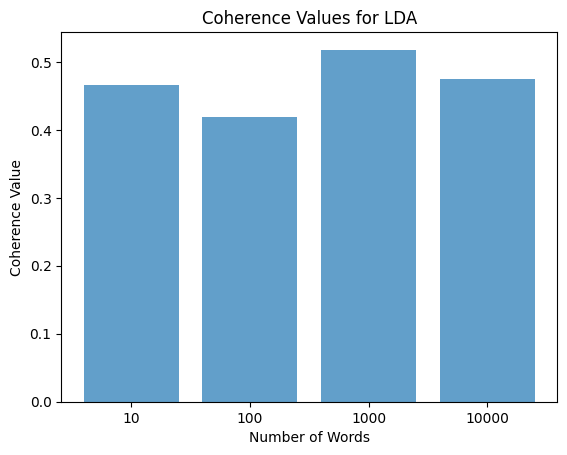

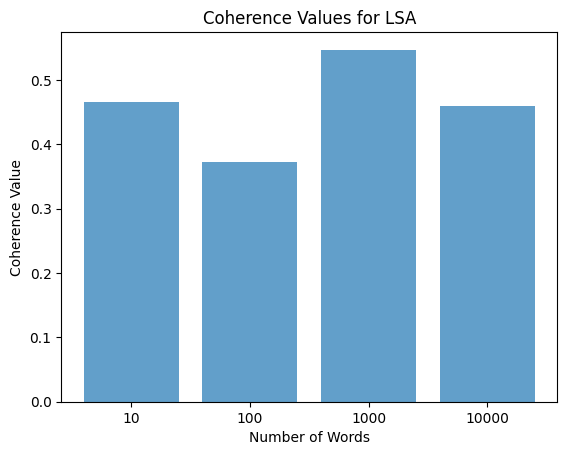

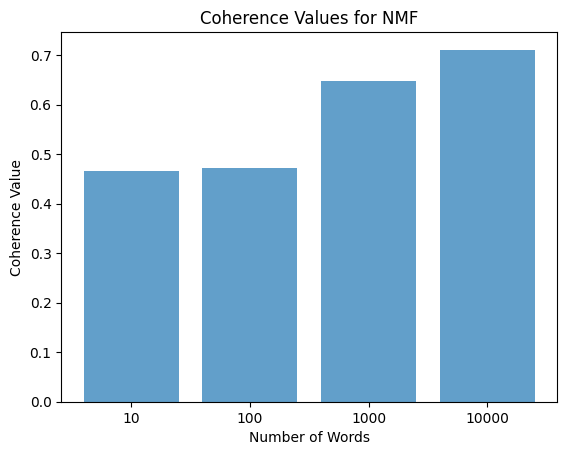

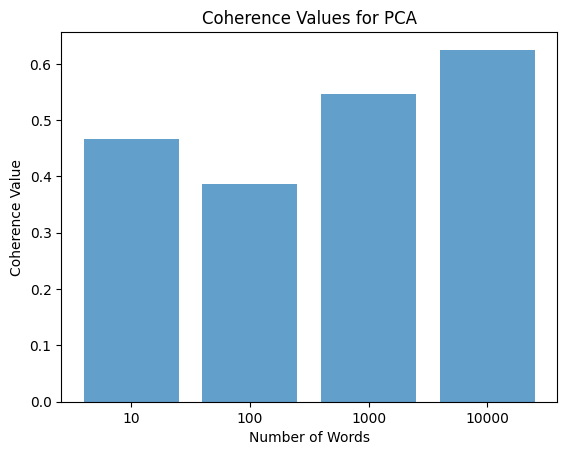

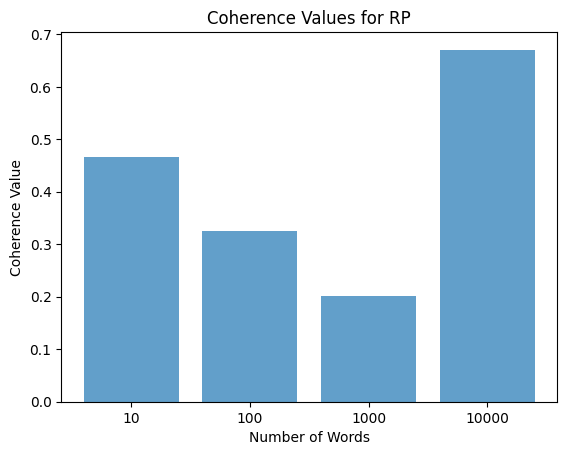

In [23]:
for model in models:
    metrics = evaluation_words[model]
    words, coherence_values = zip(*metrics)

    # Convert words to string for plotting
    words_str = list(map(str, words))

    # Create a bar plot
    plt.bar(words_str, coherence_values, align='center', alpha=0.7)
    plt.xlabel('Number of Words')
    plt.ylabel('Coherence Value')
    plt.title(f'Coherence Values for {model}')
    plt.show()

Now we'll fit the LDA model with the number of topics that yields the highest coherence

In [11]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5,
                     alpha='symmetric', eta='auto', passes=5, random_state=1)

In [12]:
for topic in lda_model.print_topics(num_words=15):
    topic_index, words = topic
    word_list = [word.split("*")[1].strip().strip('"') for word in words.split(" + ")]
    print(f"Topic {topic_index}: {', '.join(word_list)}")

Topic 0: car, drive, bike, sale, buy, speed, sell, price, distribution, game, motorcycle, usa, scsi, power, work
Topic 1: window, file, email, system, key, program, chip, computer, help, phone, software, version, work, problem, card
Topic 2: god, christian, jesus, bible, christ, religion, morality, christianity, church, faith, objective, believe, sin, truth, belief
Topic 3: beast, anthony, walker, mask, amanda, duo, murphy, pt, intercon, hamburg, singapore, cs, alex, vesselin, stats
Topic 4: government, state, year, israel, israeli, armenian, law, writes, kill, world, gun, child, case, david, post


In [13]:
import pyLDAvis, pyLDAvis.gensim

In [14]:
# Visualize the LDA model using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='tsne')
pyLDAvis.display(vis)

Now we're going to do the same for LSA

In [15]:
lsi_model = LsiModel(corpus, id2word=dictionary, num_topics=5)

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\li

In [16]:
for topic in lsi_model.print_topics():
    topic_index, words = topic
    word_list = [word.split("*")[1].strip().strip('"') for word in words.split(" + ")]
    print(f"Topic {topic_index}: {', '.join(word_list)}")

Topic 0: system, work, window, god, problem, year, drive, distribution, file, computer
Topic 1: god, window, file, card, drive, christian, jesus, driver, program, believe
Topic 2: game, god, team, window, player, file, play, year, win, christian
Topic 3: key, chip, god, clipper, encryption, government, window, game, escrow, christian
Topic 4: drive, window, file, car, scsi, game, team, program, ide, key
